In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from pyFish import Characterize
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.signal

In [272]:
t, Mx, My, M = np.loadtxt('ga_sim_data/ga_pairwise.csv', delimiter=',').T

In [273]:
np.cumsum(t)[-1]

476388.2472564721

In [27]:
np.arange(0, np.cumsum(t)[-1], t.mean())

array([0.00000000e+00, 4.77073413e-01, 9.54146825e-01, ...,
       4.77059100e+04, 4.77063871e+04, 4.77068642e+04])

In [167]:
T = np.cumsum(t).round(3)
Trs = np.arange(0, np.cumsum(t)[-1], 0.12).round(3)

In [168]:
T.shape, Trs.shape

((100000,), (397562,))

In [172]:
Trs[0:100]

array([ 0.  ,  0.12,  0.24,  0.36,  0.48,  0.6 ,  0.72,  0.84,  0.96,
        1.08,  1.2 ,  1.32,  1.44,  1.56,  1.68,  1.8 ,  1.92,  2.04,
        2.16,  2.28,  2.4 ,  2.52,  2.64,  2.76,  2.88,  3.  ,  3.12,
        3.24,  3.36,  3.48,  3.6 ,  3.72,  3.84,  3.96,  4.08,  4.2 ,
        4.32,  4.44,  4.56,  4.68,  4.8 ,  4.92,  5.04,  5.16,  5.28,
        5.4 ,  5.52,  5.64,  5.76,  5.88,  6.  ,  6.12,  6.24,  6.36,
        6.48,  6.6 ,  6.72,  6.84,  6.96,  7.08,  7.2 ,  7.32,  7.44,
        7.56,  7.68,  7.8 ,  7.92,  8.04,  8.16,  8.28,  8.4 ,  8.52,
        8.64,  8.76,  8.88,  9.  ,  9.12,  9.24,  9.36,  9.48,  9.6 ,
        9.72,  9.84,  9.96, 10.08, 10.2 , 10.32, 10.44, 10.56, 10.68,
       10.8 , 10.92, 11.04, 11.16, 11.28, 11.4 , 11.52, 11.64, 11.76,
       11.88])

In [173]:
T[0:100]

array([ 0.833,  1.343,  2.727,  2.88 ,  3.695,  3.919,  4.217,  4.525,
        4.609,  4.747,  5.284,  5.295,  5.603,  6.06 ,  6.358,  7.093,
        8.261,  8.997, 10.406, 10.829, 11.579, 11.656, 11.677, 12.246,
       14.243, 14.377, 14.762, 15.48 , 15.622, 15.8  , 16.29 , 16.646,
       17.513, 17.667, 17.722, 18.843, 18.909, 19.295, 20.536, 22.56 ,
       22.942, 23.072, 23.406, 23.437, 24.24 , 25.539, 25.983, 26.439,
       28.153, 28.215, 28.563, 29.027, 29.225, 30.324, 30.983, 31.695,
       32.28 , 33.054, 33.228, 33.316, 33.464, 35.011, 35.58 , 35.941,
       36.086, 37.488, 38.587, 39.094, 39.631, 40.048, 40.952, 41.365,
       41.614, 41.82 , 41.982, 43.476, 43.979, 43.985, 44.396, 47.201,
       48.671, 48.75 , 48.784, 49.094, 49.123, 50.321, 51.031, 51.127,
       52.008, 52.184, 53.471, 53.525, 54.141, 54.18 , 54.874, 54.888,
       56.063, 56.146, 56.433, 56.595])

In [205]:
flag = 1
j = 0
t_ = np.zeros(len(Trs))
for i in range(len(Trs)):
    if flag == 1:
        t_[i] = Trs[i]
        flag = 0
    else:
        t_[i] = np.nan
    if Trs[i] > T[j]:
        j = j + 1
        flag = 1

In [194]:
len(t_), len(Trs)

(397562, 397562)

In [199]:
t_[0:100]

array([ 0.  ,   nan,   nan,   nan,   nan,   nan,   nan,   nan,  0.96,
         nan,   nan,   nan,   nan,  1.56,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan,   nan,  2.88,   nan,  3.12,
         nan,   nan,   nan,   nan,   nan,  3.84,   nan,  4.08,   nan,
         nan,  4.44,   nan,  4.68,  4.8 ,  4.92,   nan,   nan,   nan,
         nan,  5.52,  5.64,  5.76,   nan,   nan,   nan,  6.24,   nan,
        6.48,   nan,   nan,   nan,   nan,   nan,   nan,  7.32,   nan,
         nan,   nan,   nan,   nan,   nan,   nan,   nan,  8.4 ,   nan,
         nan,   nan,   nan,   nan,  9.12,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan,   nan,   nan, 10.56,   nan,
         nan,   nan, 11.04,   nan,   nan,   nan,   nan,   nan, 11.76,
       11.88])

In [206]:
mx = t_.copy()

In [208]:
mx[~np.isnan(t_)] = Mx

In [246]:
def nan_helper(x):
    return np.isnan(x), lambda z: z.nonzero()[0]

def interpolate_missing(y):
    nans, x = nan_helper(y)
    y[nans] = np.interp(x(nans), x(~nans), y[~nans])
    return y

def resample(file, time_step=0.12):
    t, Mx, My, M = np.loadtxt(file, delimiter=',').T
    t = np.cumsum(t).round(3)
    t_rs = np.arange(0, t[-1], time_step).round(3)
    
    flag = 1
    j = 0
    T = np.zeros(len(t_rs))
    for i in range(len(t_rs)):
        if flag == 1:
            T[i] = t_rs[i]
            flag = 0
        else:
            T[i] = np.nan
        if t_rs[i] > t[j]:
            j = j + 1
            flag = 1
    mx = T.copy()
    my = T.copy()
    mx[~np.isnan(T)] = Mx
    my[~np.isnan(T)] = My
    mx = interpolate_missing(mx)
    my = interpolate_missing(my)
    return t_rs, mx, my, np.sqrt(mx**2 + my**2)

In [366]:
t, Mx, My, M = resample('ga_sim_data/ga_ternary.csv')

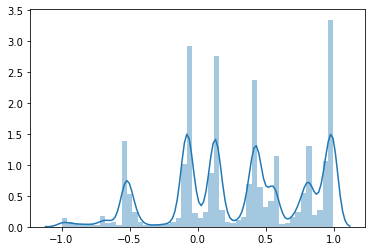

In [369]:
sns.distplot(My)

In [370]:
Mx[0:100]

array([ 0.10028   ,  0.0839155 ,  0.067551  ,  0.021261  , -0.0068218 ,
       -0.043908  , -0.0701815 , -0.096455  , -0.0880015 , -0.079548  ,
       -0.08520378, -0.09085956, -0.09651533, -0.10217111, -0.10782689,
       -0.11348267, -0.11913844, -0.12479422, -0.13045   , -0.1342625 ,
       -0.138075  , -0.1418875 , -0.1457    , -0.15352   , -0.14371   ,
       -0.1339    , -0.13859   , -0.1280038 , -0.1174176 , -0.1068314 ,
       -0.0962452 , -0.085659  , -0.086969  , -0.088279  , -0.0989645 ,
       -0.10965   , -0.11012   , -0.11059   , -0.11106   , -0.11153   ,
       -0.112     , -0.11247   , -0.11294   , -0.11341   , -0.11388   ,
       -0.11435   , -0.11482   , -0.11529   , -0.11576   , -0.07689   ,
       -0.038388  , -0.032317  , -0.026246  , -0.020175  , -0.0124169 ,
       -0.0046588 ,  0.061828  ,  0.0605115 ,  0.059195  ,  0.0465355 ,
        0.033876  ,  0.0112375 , -0.011401  , -0.013355  , -0.015309  ,
       -0.017263  , -0.019217  , -0.058096  , -0.11832   , -0.11

In [371]:
ch = Characterize([Mx, My], t=None, t_int=np.cumsum(t)[-1]/len(t), dt=416)

Gaussian check for underlying noise: 100%|██████████| 10000/10000 [00:00<00:00, 14815.17it/s]


In [372]:
ch.parameters()

{'dt_': '416',
 't_int': '22661.82',
 't_lag': '1000',
 'simple_method': 'True',
 'max_order': '10',
 'inc': '0.01',
 'inc_x': '0.1',
 'inc_y': '0.1',
 'delta_t': '1',
 'order_metric': 'R2_adj',
 'fft': 'True',
 'drift_order': '1',
 'diff_order': '6',
 'n_trials': '1',
 'vector': 'True',
 'autocorrelation_time': '615.6960043906249',
 'dt': '416',
 'gaussian_noise': 'True',
 'k': '0.007751354529533942',
 'l_lim': '-109.302449831106',
 'h_lim': '99.71891378988974'}

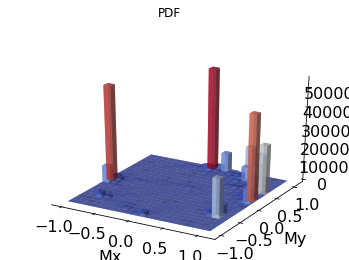

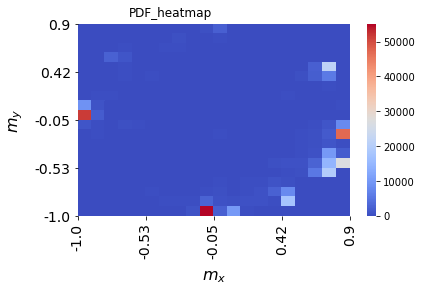

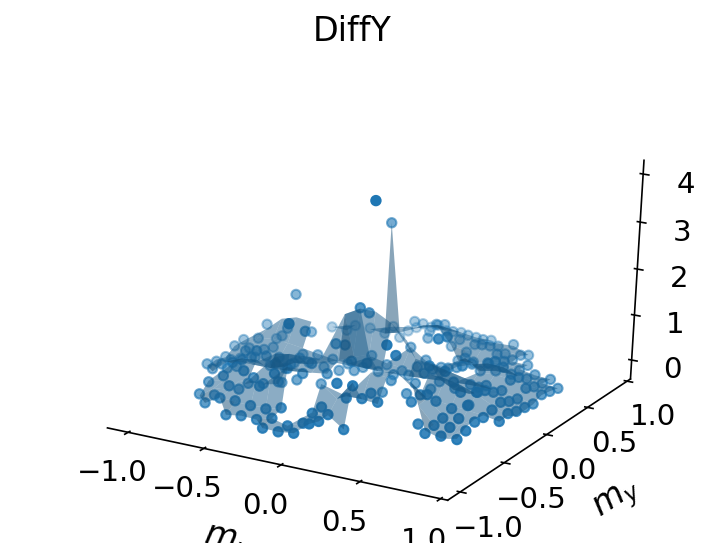

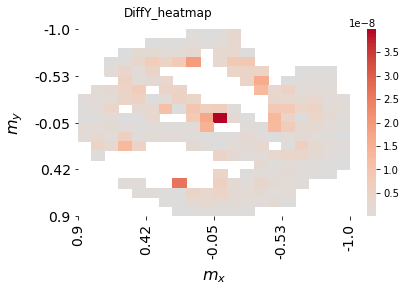

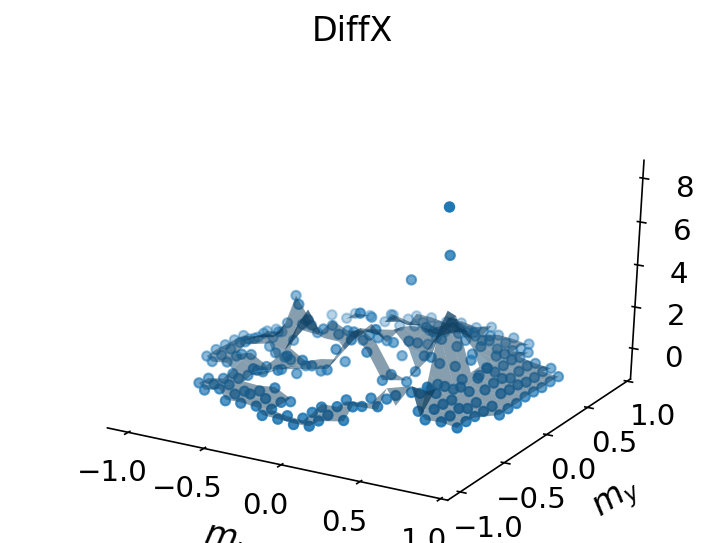

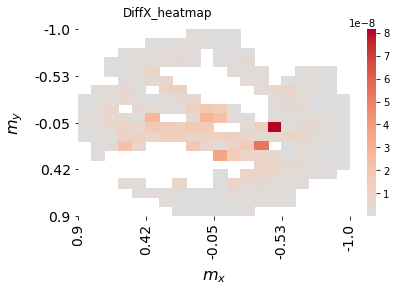

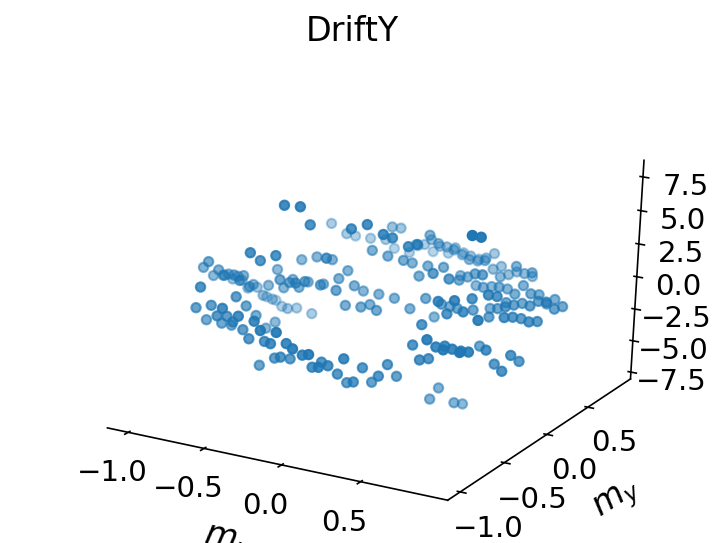

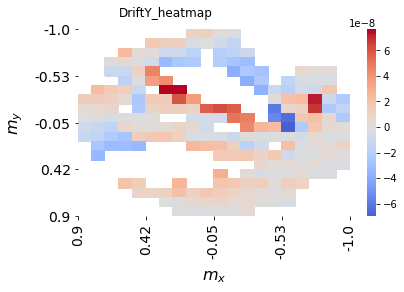

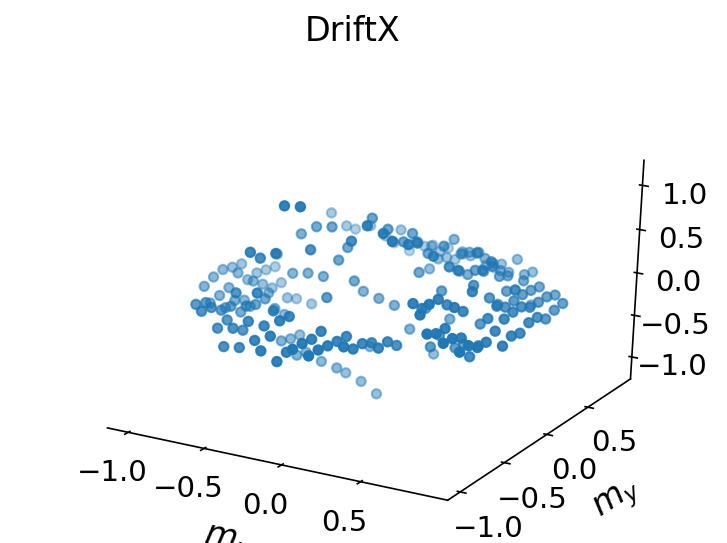

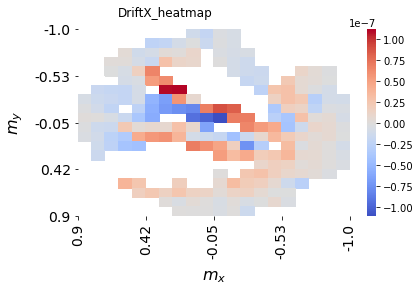

In [374]:
ch.visualize()

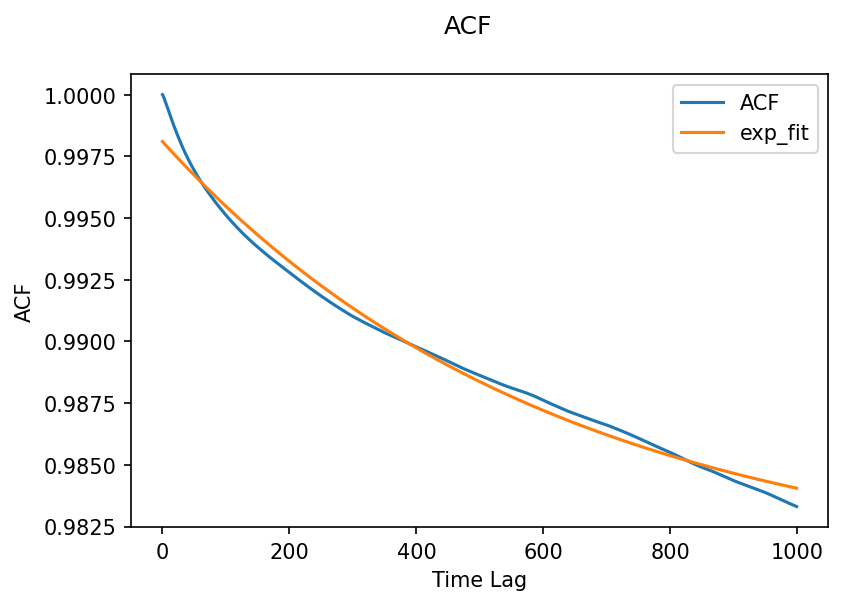

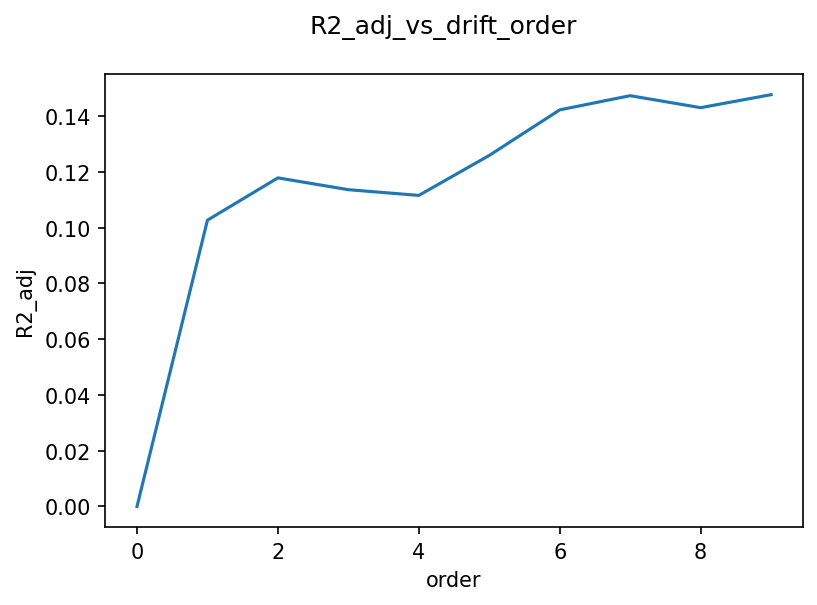

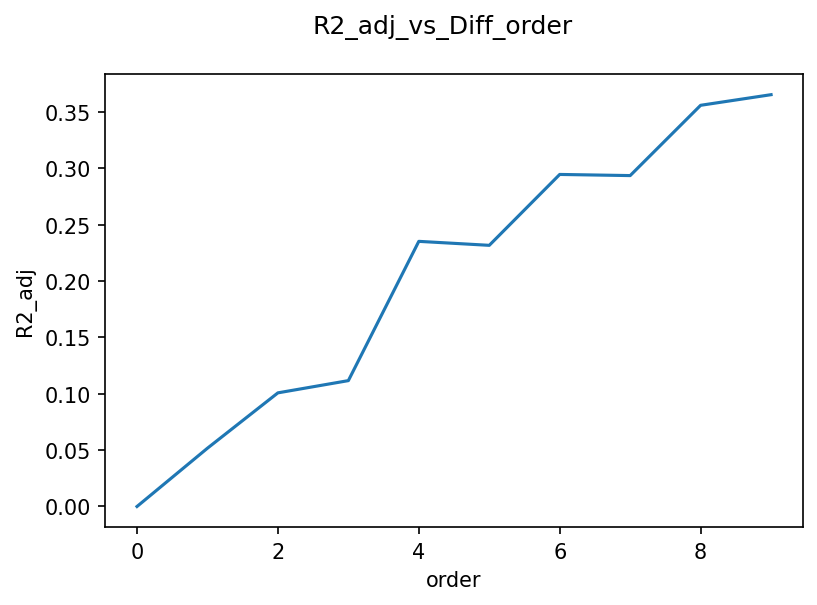

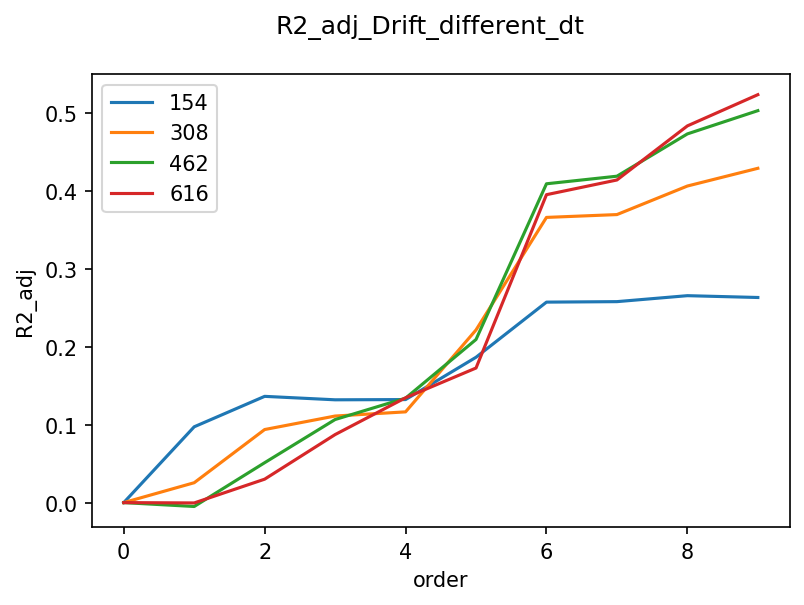

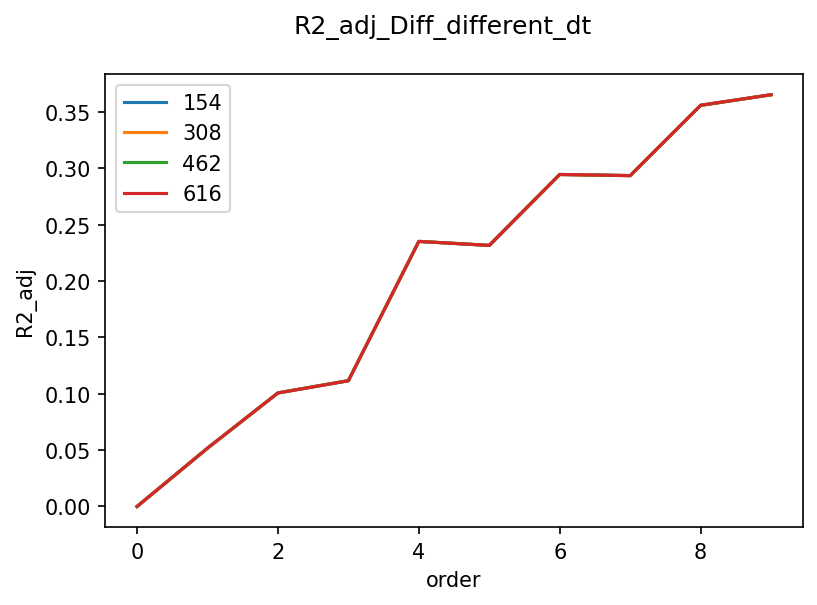

In [375]:
ch.diagnostic()

In [5]:
# -*- coding: utf-8 -*-
"""
Created on Fri Jan 17 12:25:39 2020

@author: Ashwin
"""

import matplotlib.pyplot as plt
import numpy as np
import itertools
import random
import tqdm

N = 15
noise = 1
rates = [0.1, 2]
system_state = np.random.uniform(0,2*np.pi, size = N)
iter_ = 10**6
clock = 0
M = []
Mx = []
My = []
time_steps = []
t = np.array([np.random.exponential((1/r), N) if r else np.ones(N)*np.nan for r in rates])

def polarity(vector):
    Mx = np.sum(np.cos(vector))/len(vector)
    My = np.sum(np.sin(vector))/len(vector)
    return Mx, My, np.round(np.sqrt(Mx**2 + My**2), 3)

def spontaneous_event():
    l = np.random.randint(N)
    system_state[l] = system_state[l] + np.random.normal(-noise/2, noise/2)

def get_order():
    time_frame = np.where(t == np.nanmin(t))
    return time_frame[0][0], time_frame

def non_spontaneous_event(order):
    L = random.sample(range(0,N), order+1)
    ss = system_state[L]
    if order == 1:
        system_state[L[0]] = system_state[L[1]]
    else:
        groups = list(itertools.combinations(system_state[L], order))
        gP = [polarity(g) for g in groups]
        max_p = groups[np.where(gP == np.amax(gP))[0][0]]
        for s in range(len(ss)):
            if ss[s] not in max_p:
                break
        system_state[L[s]] = np.mean(max_p)

def update_time(time_frame):
    t_ = t - t[time_frame]
    t_[time_frame] = np.random.exponential((1/rates[time_frame[0][0]]))
    return t_

for _ in tqdm.tqdm(range(iter_)):
    order, time_frame = get_order()
    if not order:
        spontaneous_event()
    else:
        non_spontaneous_event(order)
    clock = clock + t[time_frame]
    mx, my, m = polarity(system_state)
    Mx.append(mx)
    My.append(my)
    time_steps.append(clock[0])
    t = update_time(time_frame)
Mx = np.array(Mx)
My = np.array(My)
sns.distplot(Mx)

 15%|█▍        | 148308/1000000 [00:11<01:05, 13039.41it/s]


KeyboardInterrupt: 

In [325]:
np.array(time_steps)[-1]/len(time_steps)

0.03177970994318027

In [326]:
ch = Characterize([Mx, My], t=None, t_int=np.array(time_steps)[-1]/len(time_steps), dt='auto')

Gaussian check for underlying noise: 100%|██████████| 10000/10000 [00:01<00:00, 5515.62it/s]


In [327]:
ch.parameters()

{'dt_': 'auto',
 't_int': '0.03177970994318027',
 't_lag': '1000',
 'simple_method': 'True',
 'max_order': '10',
 'inc': '0.01',
 'inc_x': '0.1',
 'inc_y': '0.1',
 'delta_t': '1',
 'order_metric': 'R2_adj',
 'fft': 'True',
 'drift_order': '1',
 'diff_order': '2',
 'n_trials': '1',
 'vector': 'True',
 'autocorrelation_time': '93.75724706179889',
 'dt': '93',
 'gaussian_noise': 'True',
 'k': '26.047646497289563',
 'l_lim': '-199.6866305550127',
 'h_lim': '193.36239064264572'}

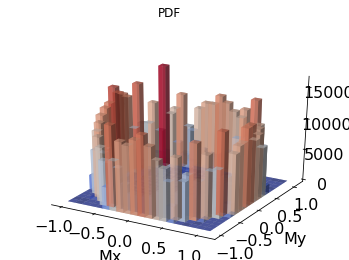

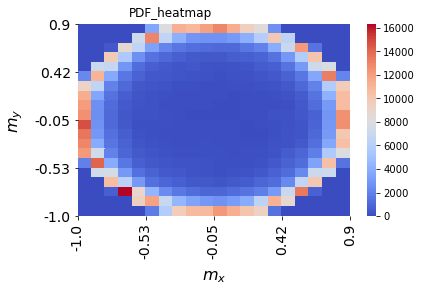

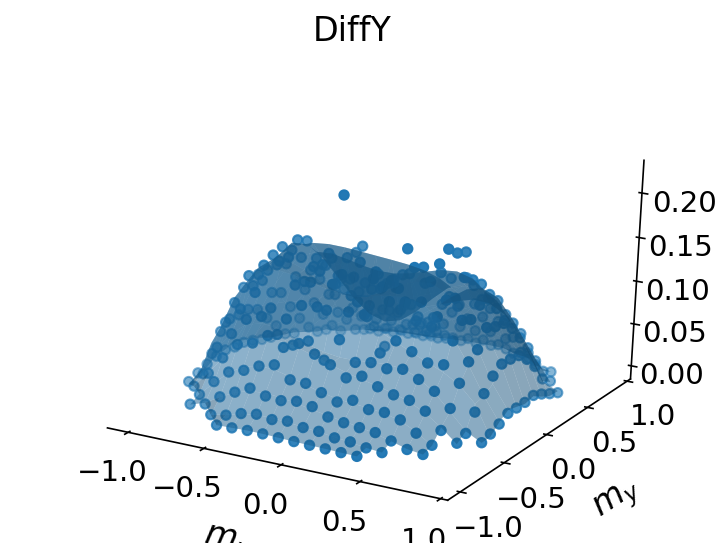

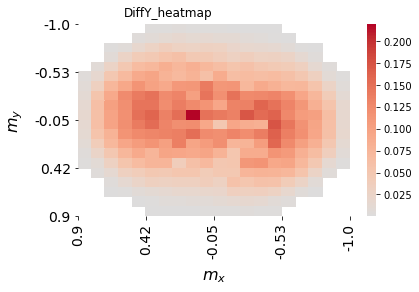

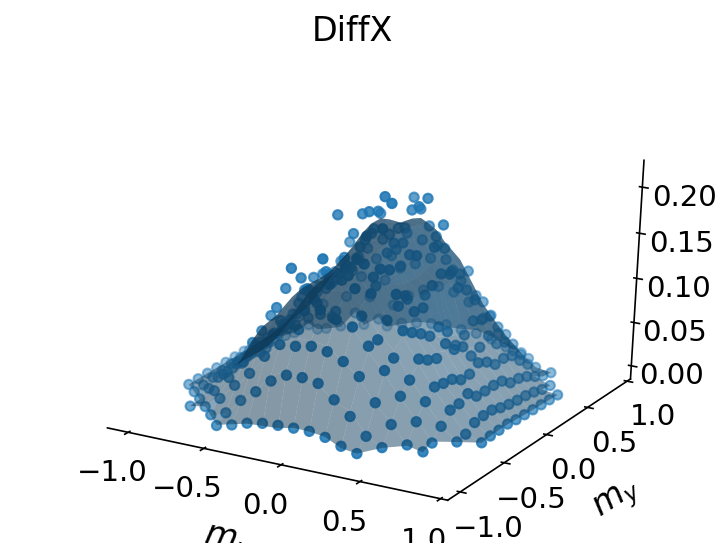

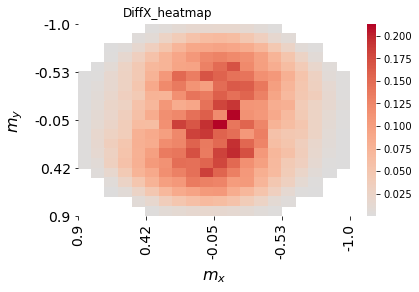

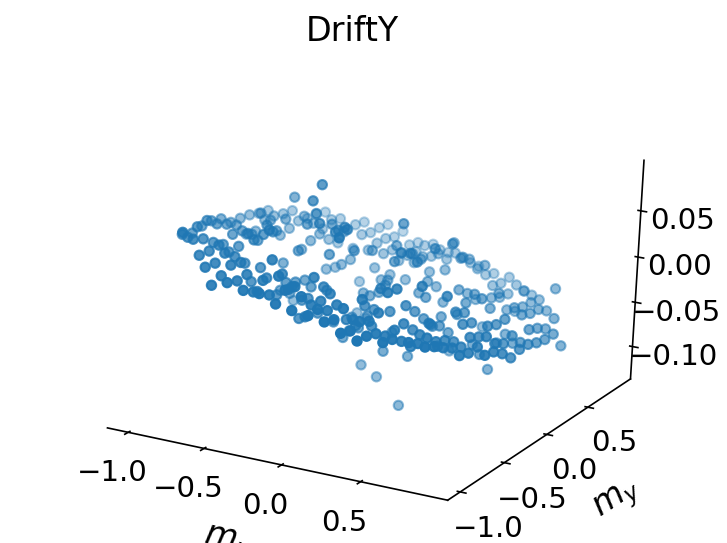

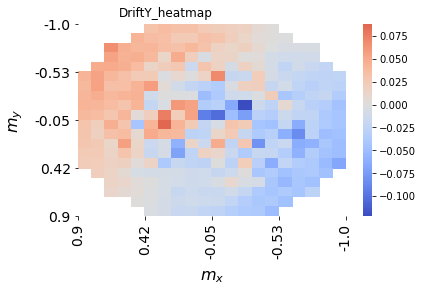

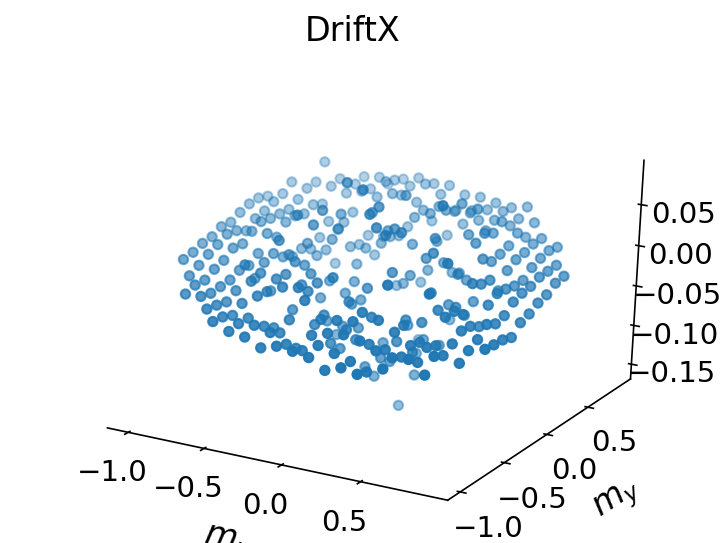

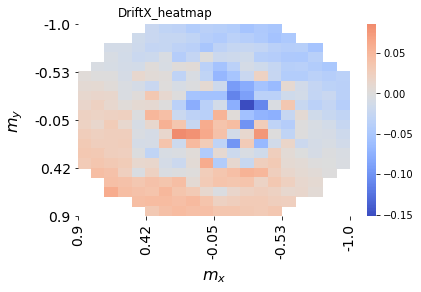

In [328]:
ch.visualize()

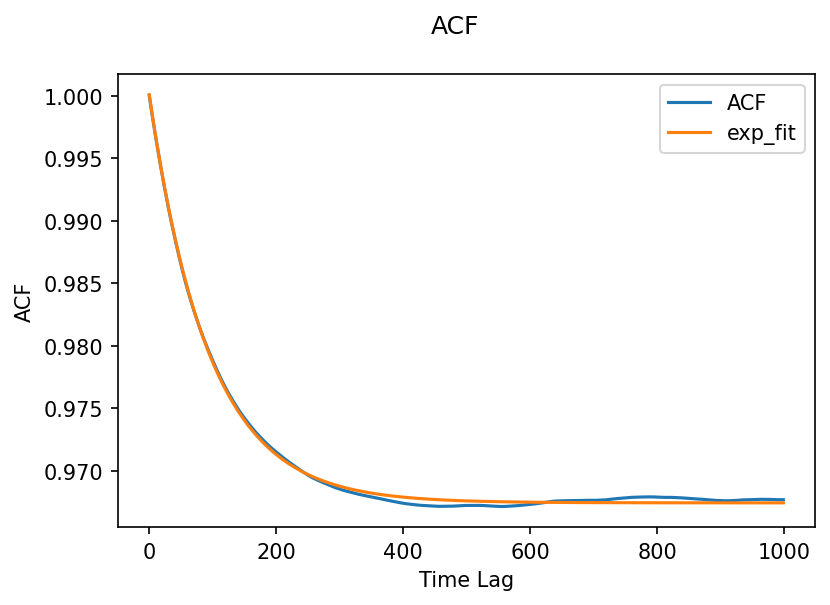

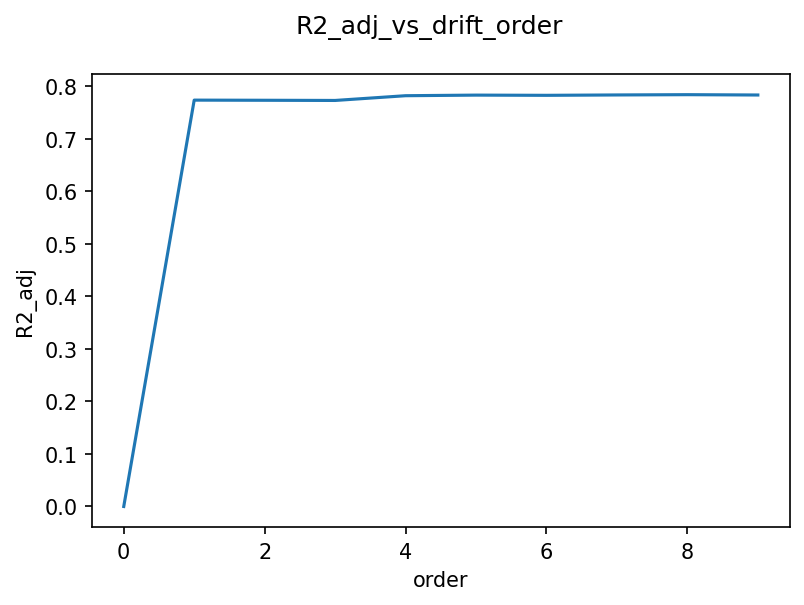

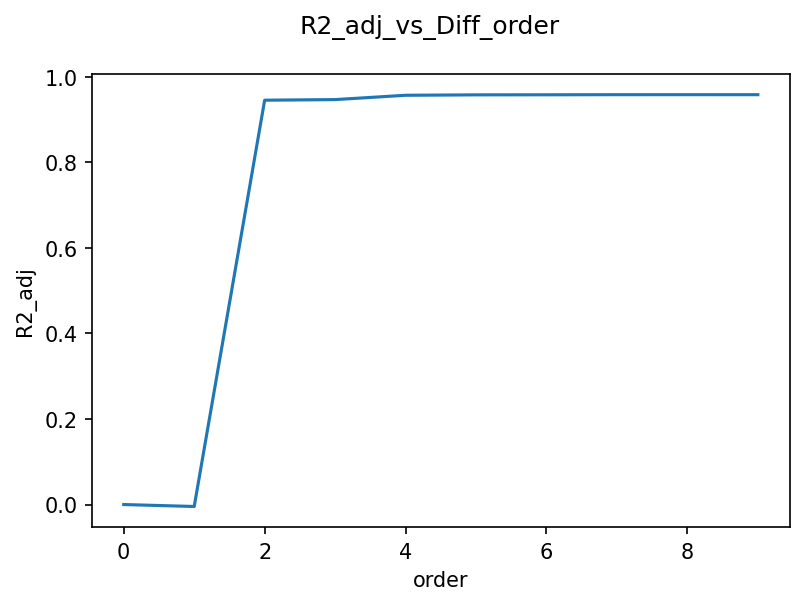

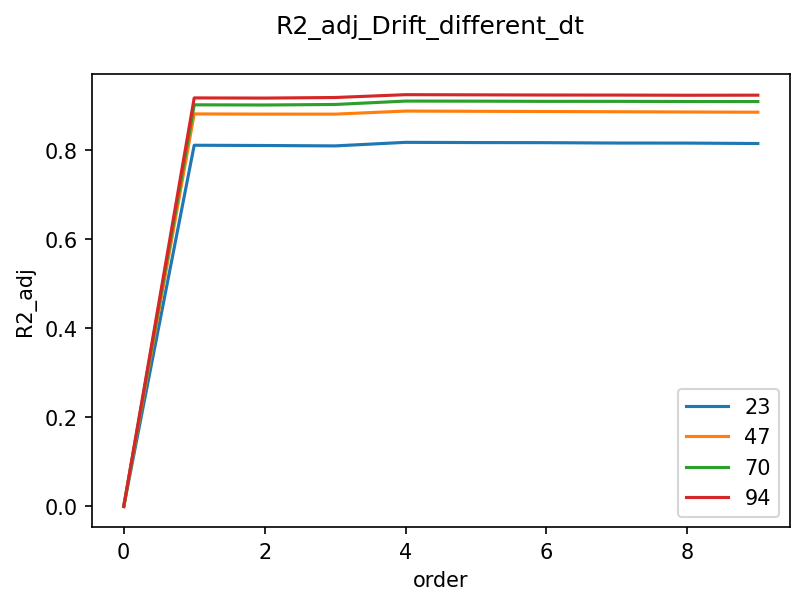

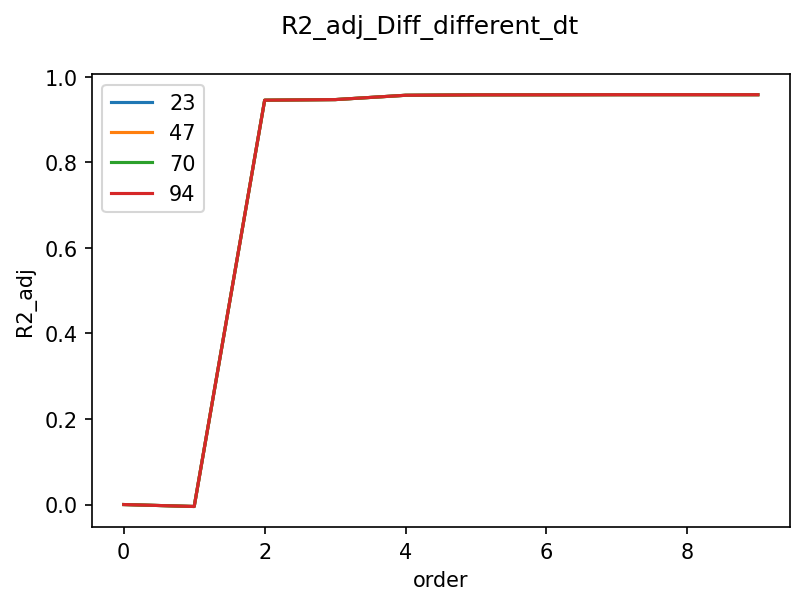

In [329]:
ch.diagnostic()

In [6]:
# -*- coding: utf-8 -*-
"""
Created on Fri Jan 17 12:25:39 2020

@author: Ashwin
"""
def generate_ga_data(N=15, noise=1, rates=[0.1,2], iter_=10**6):
    system_state = np.random.uniform(0,2*np.pi, size = N)
    clock = 0
    M = []
    Mx = []
    My = []
    time_steps = []
    t = np.array([np.random.exponential((1/r), N) if r else np.ones(N)*np.nan for r in rates])

    def polarity(vector):
        Mx = np.sum(np.cos(vector))/len(vector)
        My = np.sum(np.sin(vector))/len(vector)
        return Mx, My, np.round(np.sqrt(Mx**2 + My**2), 3)

    def spontaneous_event():
        l = np.random.randint(N)
        system_state[l] = system_state[l] + np.random.normal(-noise/2, noise/2)

    def get_order():
        time_frame = np.where(t == np.nanmin(t))
        return time_frame[0][0], time_frame

    def non_spontaneous_event(order):
        L = random.sample(range(0,N), order+1)
        ss = system_state[L]
        if order == 1:
            system_state[L[0]] = system_state[L[1]]
        else:
            groups = list(itertools.combinations(system_state[L], order))
            gP = [polarity(g) for g in groups]
            max_p = groups[np.where(gP == np.amax(gP))[0][0]]
            for s in range(len(ss)):
                if ss[s] not in max_p:
                    break
            system_state[L[s]] = np.mean(max_p)

    def update_time(time_frame):
        t_ = t - t[time_frame]
        t_[time_frame] = np.random.exponential((1/rates[time_frame[0][0]]))
        return t_

    for _ in tqdm.tqdm(range(iter_)):
        order, time_frame = get_order()
        if not order:
            spontaneous_event()
        else:
            non_spontaneous_event(order)
        clock = clock + t[time_frame]
        if clock[0] >= 0.12:
            clock = 0
            mx, my, m = polarity(system_state)
            Mx.append(mx)
            My.append(my)
            #time_steps.append(clock[0])
        t = update_time(time_frame)
    return np.array(time_steps), np.array(Mx), np.array(My)

100%|██████████| 2985984/2985984 [02:36<00:00, 19097.27it/s]


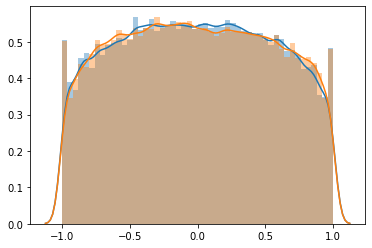

In [20]:
t, Mx, My = generate_ga_data(N=15, noise=np.pi, rates=[0.1, 2], iter_=12**6)
plt.figure()
sns.distplot(Mx)
sns.distplot(My)

In [21]:
np.savetxt('syn_pairwise.txt', np.vstack((Mx, My)).T)

In [31]:
Mx_2, My_2 = np.loadtxt('syn_pairwise.txt').T

In [33]:
ch = Characterize([Mx_2, My_2], t=None, t_int=0.12, dt='auto')
ch.parameters()

Gaussian check for underlying noise: 100%|██████████| 10000/10000 [00:02<00:00, 4869.55it/s]


{'dt_': 'auto',
 't_int': '0.12',
 't_lag': '1000',
 'simple_method': 'True',
 'max_order': '10',
 'inc': '0.01',
 'inc_x': '0.1',
 'inc_y': '0.1',
 'delta_t': '1',
 'order_metric': 'R2_adj',
 'fft': 'True',
 'drift_order': '1',
 'diff_order': '2',
 'n_trials': '1',
 'vector': 'True',
 'autocorrelation_time': '13.330889514008469',
 'dt': '13',
 'gaussian_noise': 'True',
 'k': '12.817957271861019',
 'l_lim': '-154.87459441636054',
 'h_lim': '220.95316478155888'}

<IPython.core.display.Javascript object>


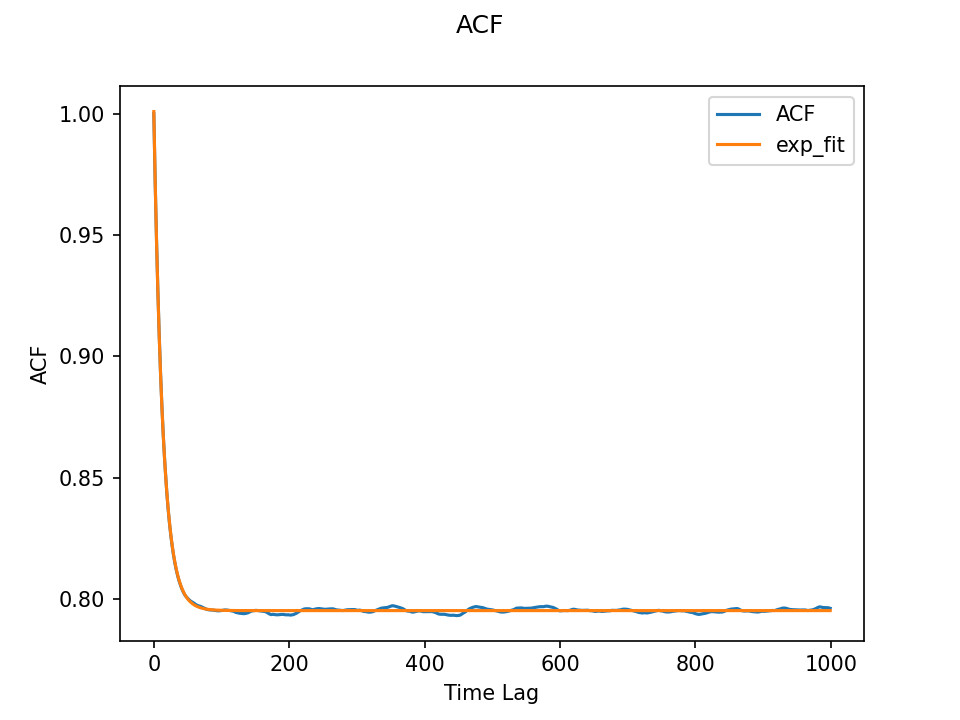

<IPython.core.display.Javascript object>


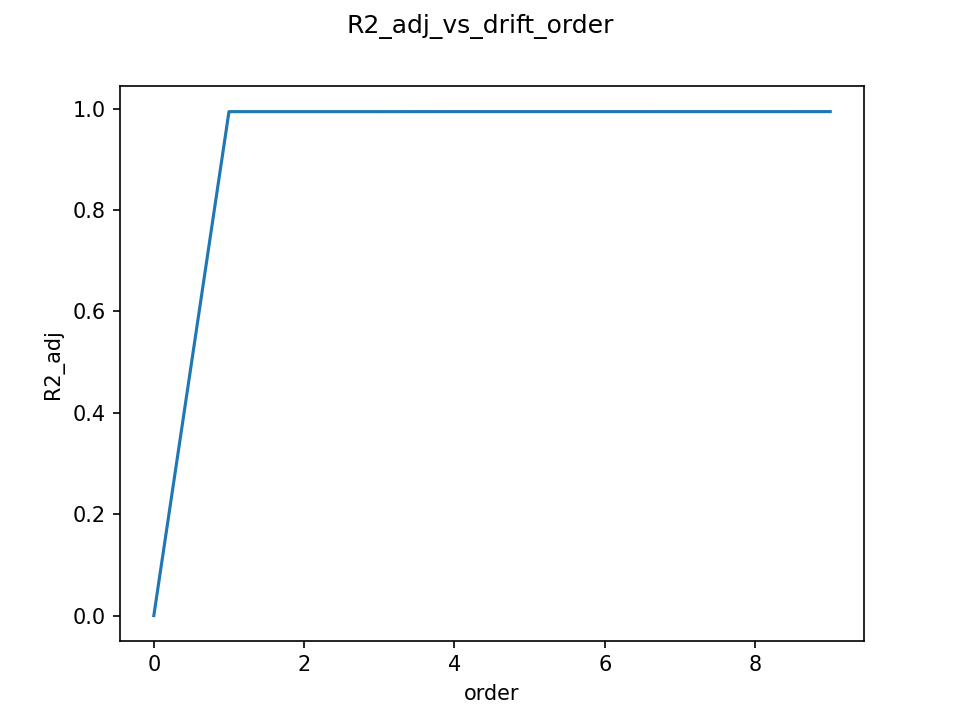

<IPython.core.display.Javascript object>


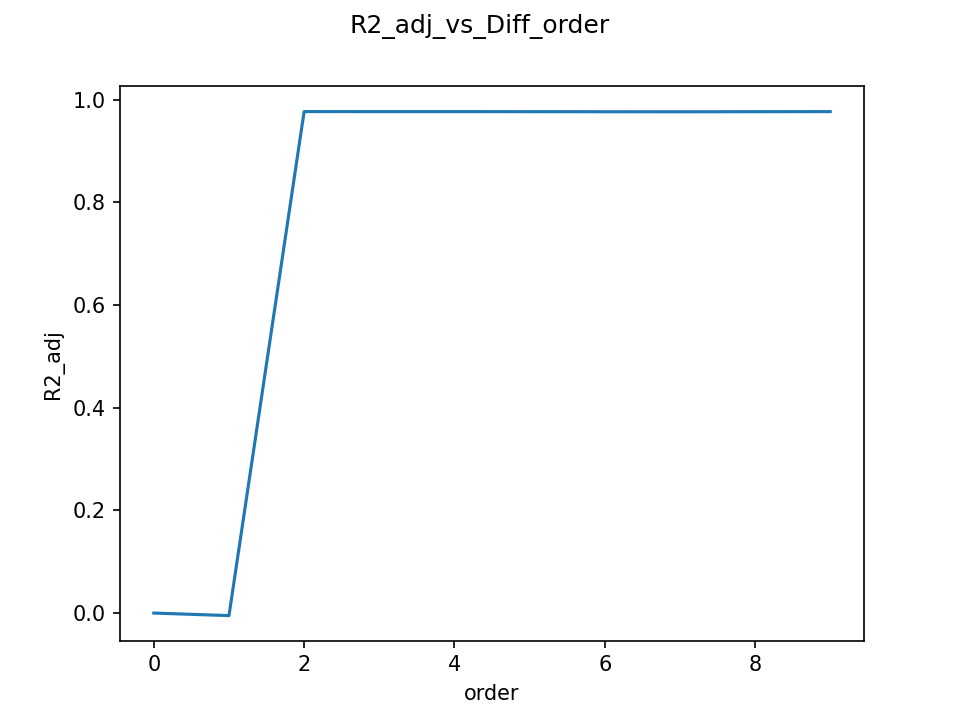

<IPython.core.display.Javascript object>


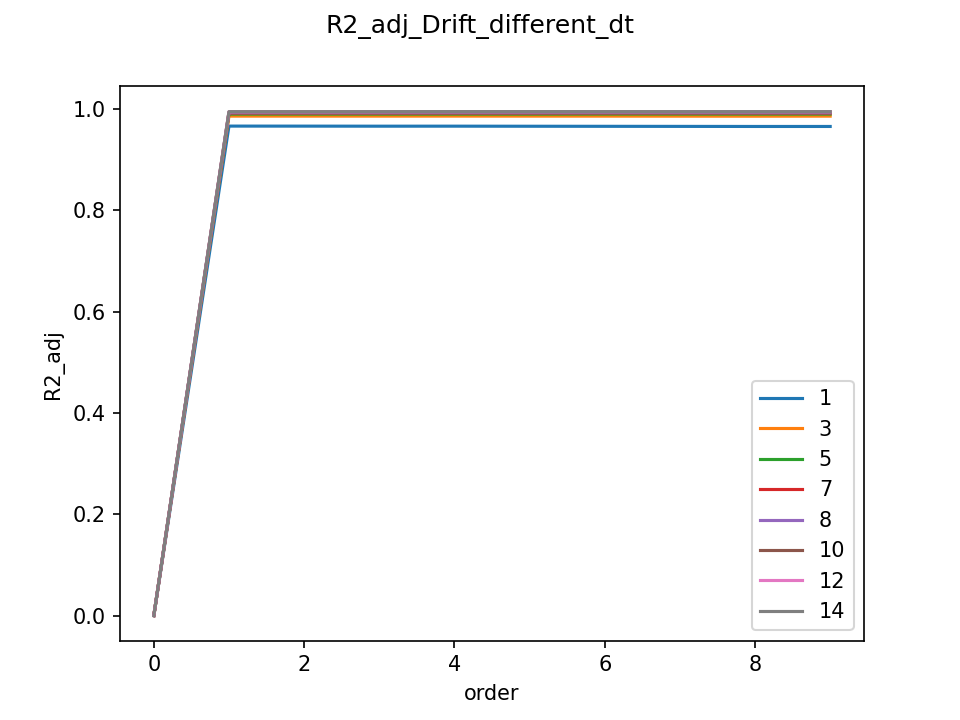

<IPython.core.display.Javascript object>


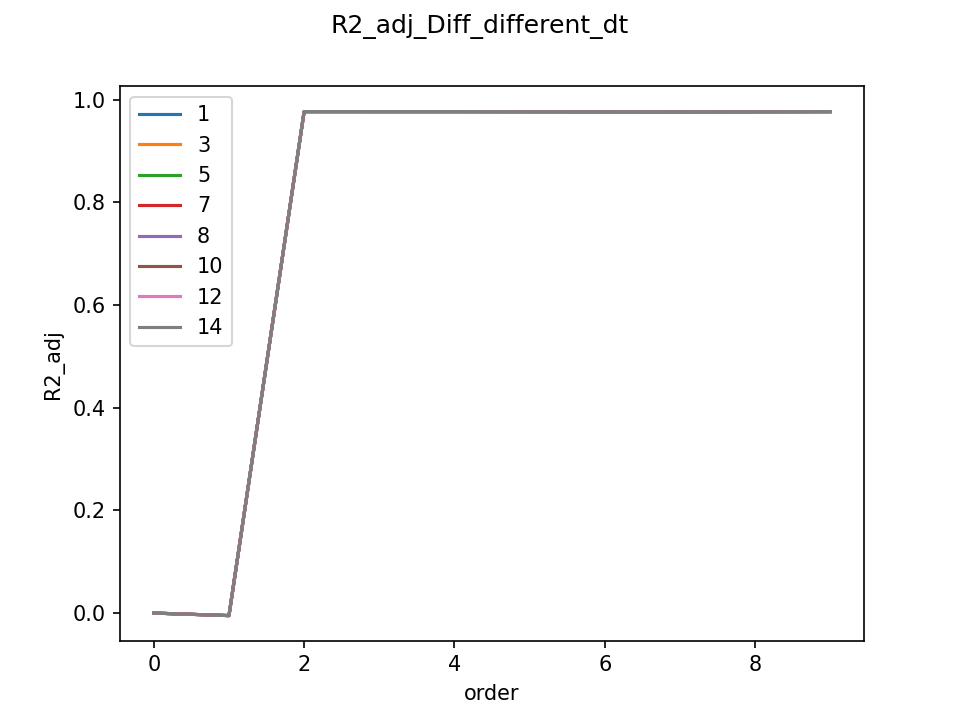

In [34]:
ch.diagnostic()

In [29]:
%matplotlib notebook

<IPython.core.display.Javascript object>


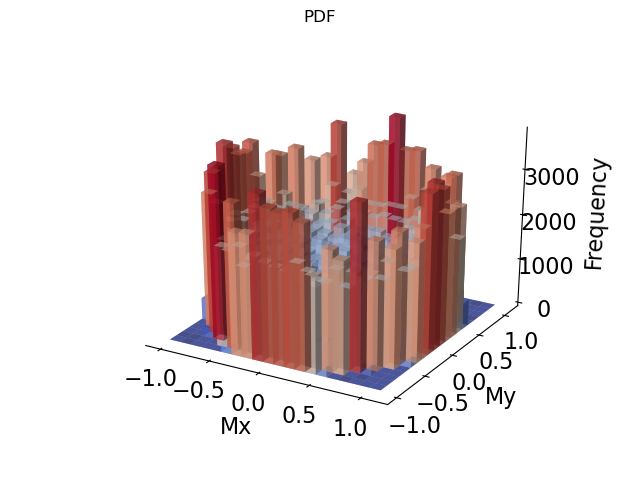

<IPython.core.display.Javascript object>


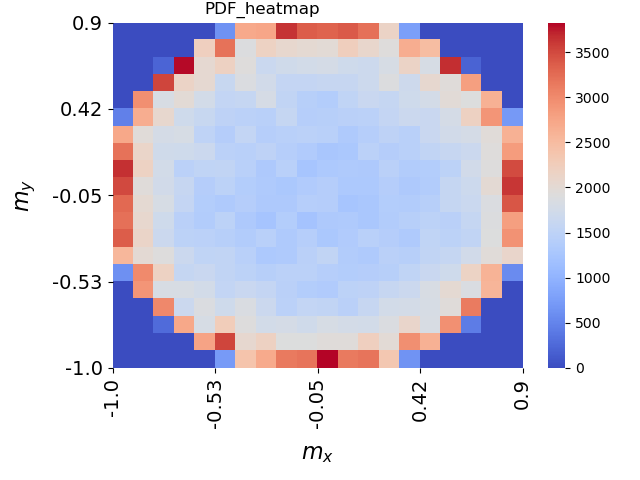

<IPython.core.display.Javascript object>


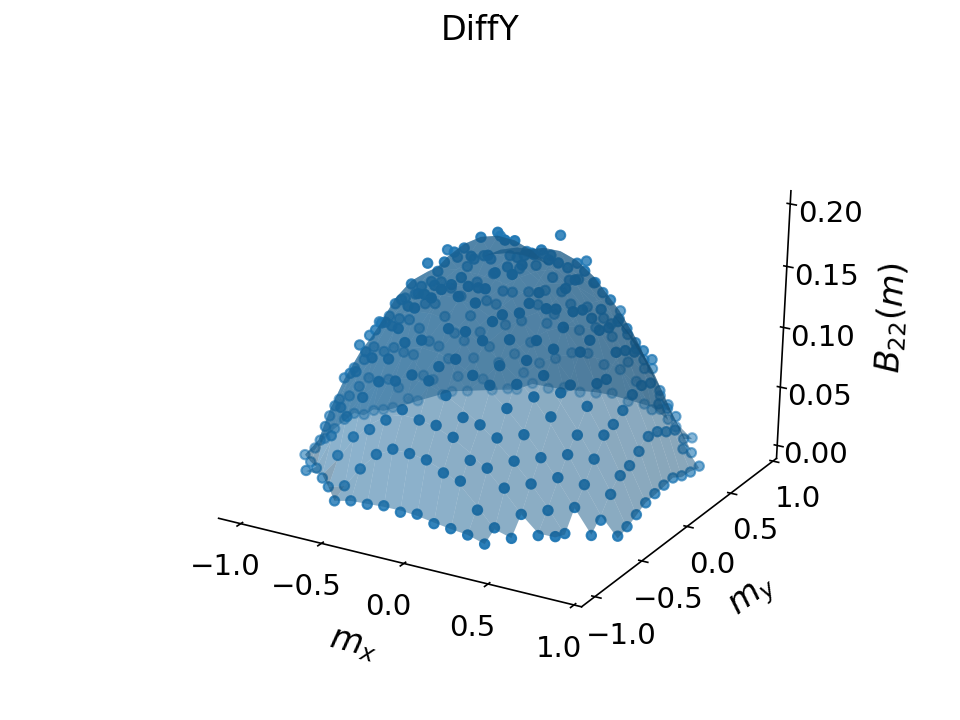

<IPython.core.display.Javascript object>


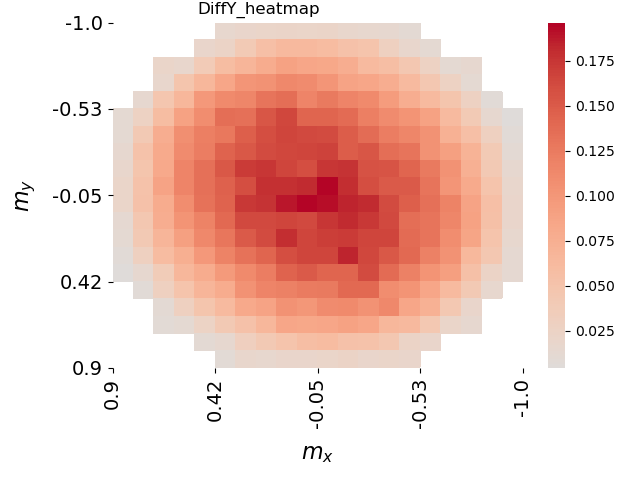

<IPython.core.display.Javascript object>


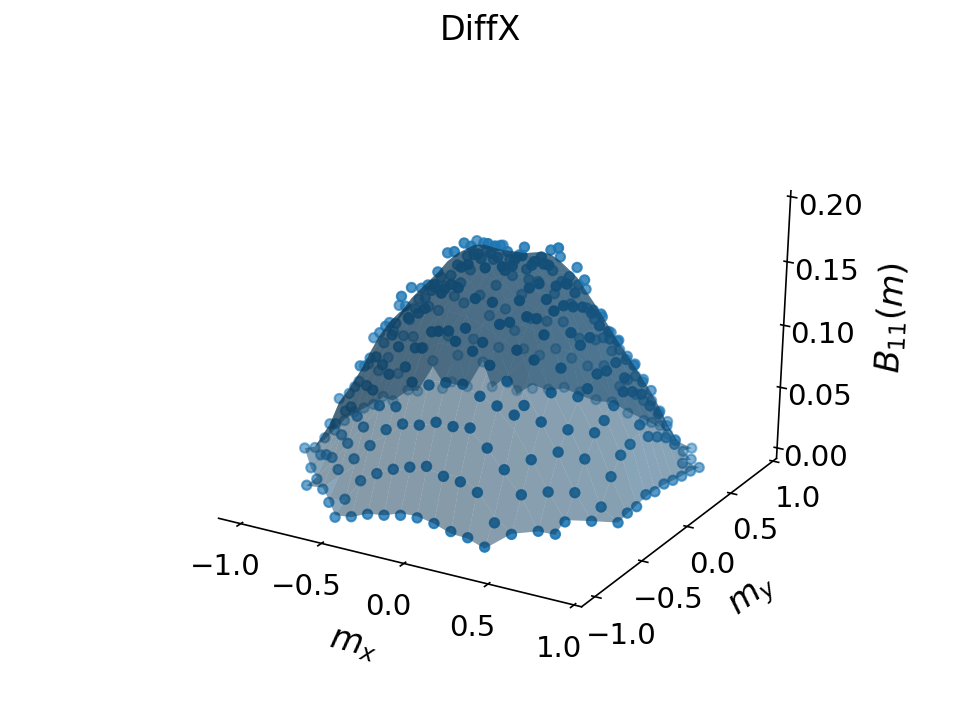

<IPython.core.display.Javascript object>


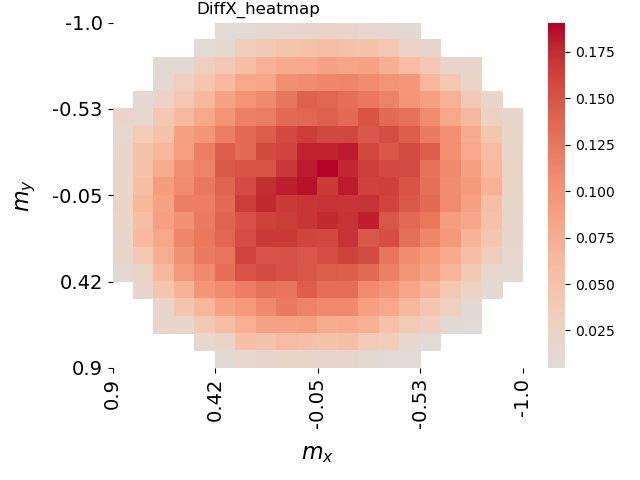

<IPython.core.display.Javascript object>


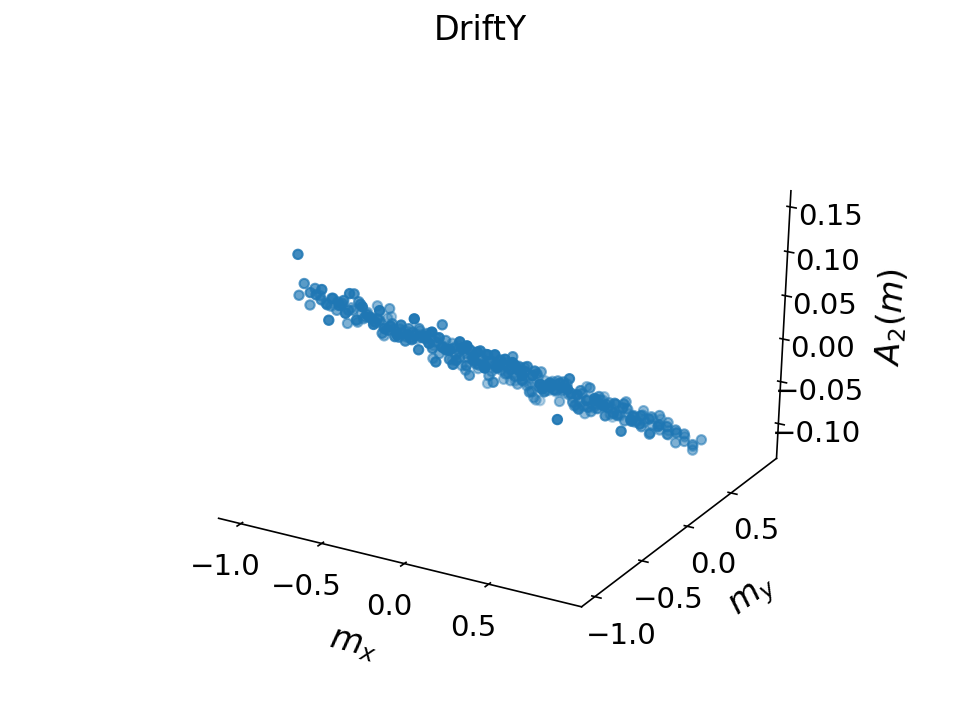

<IPython.core.display.Javascript object>


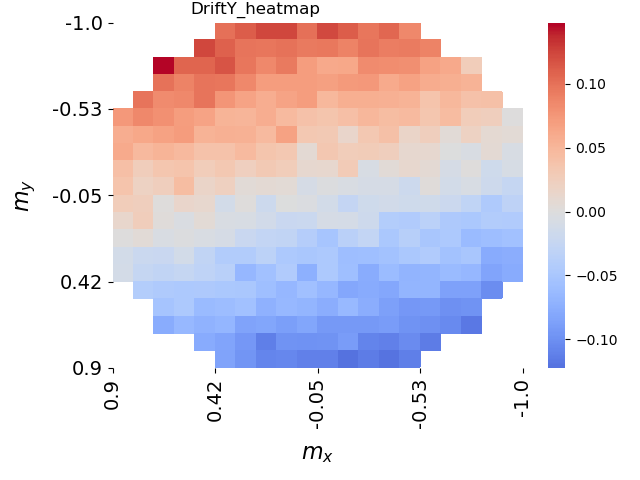

<IPython.core.display.Javascript object>


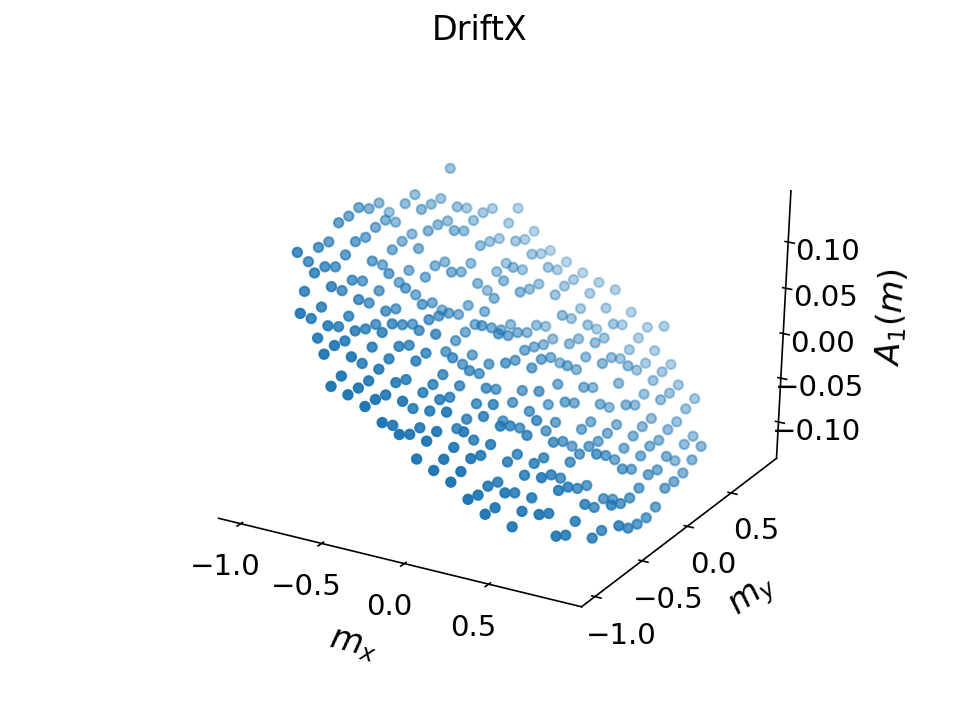

<IPython.core.display.Javascript object>


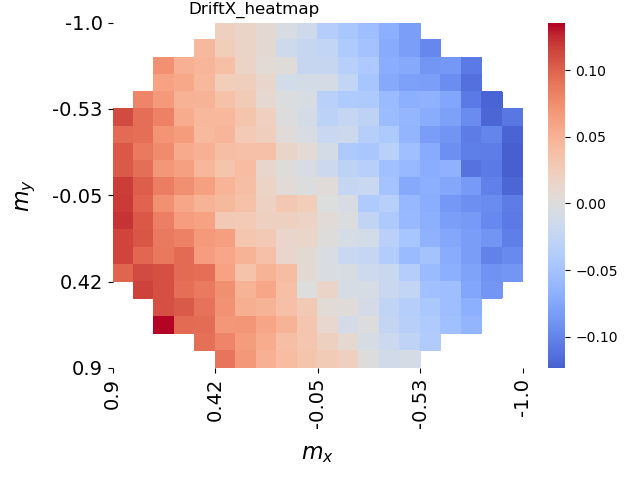

In [35]:
ch.visualize()

100%|██████████| 2985984/2985984 [03:22<00:00, 14752.13it/s]


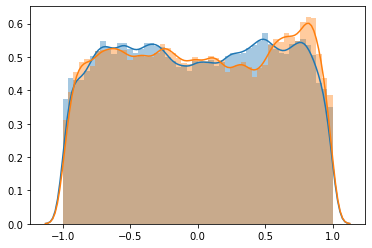

In [14]:
t, Mx, My = generate_ga_data(N=30, noise=np.pi, rates=[0.05, 1, 0.1], iter_=12**6)
plt.figure()
sns.distplot(Mx)
sns.distplot(My)

In [15]:
np.savetxt('syn_ternary.txt', np.vstack((Mx, My)).T)

In [94]:
Mx_3, My_3 = np.loadtxt('syn_ternary.txt').T

In [26]:
ch = Characterize([Mx, My], t=None, t_int=0.12, dt=4)
ch.parameters()

Gaussian check for underlying noise: 100%|██████████| 10000/10000 [00:01<00:00, 6219.45it/s]


{'dt_': '4',
 't_int': '0.12',
 't_lag': '1000',
 'simple_method': 'True',
 'max_order': '10',
 'inc': '0.01',
 'inc_x': '0.1',
 'inc_y': '0.1',
 'delta_t': '1',
 'order_metric': 'R2_adj',
 'fft': 'True',
 'drift_order': '1',
 'diff_order': '2',
 'n_trials': '1',
 'vector': 'True',
 'autocorrelation_time': '35.45905562757836',
 'dt': '4',
 'gaussian_noise': 'True',
 'k': '3.931760373750279',
 'l_lim': '-203.55338097861434',
 'h_lim': '153.03896196413268'}

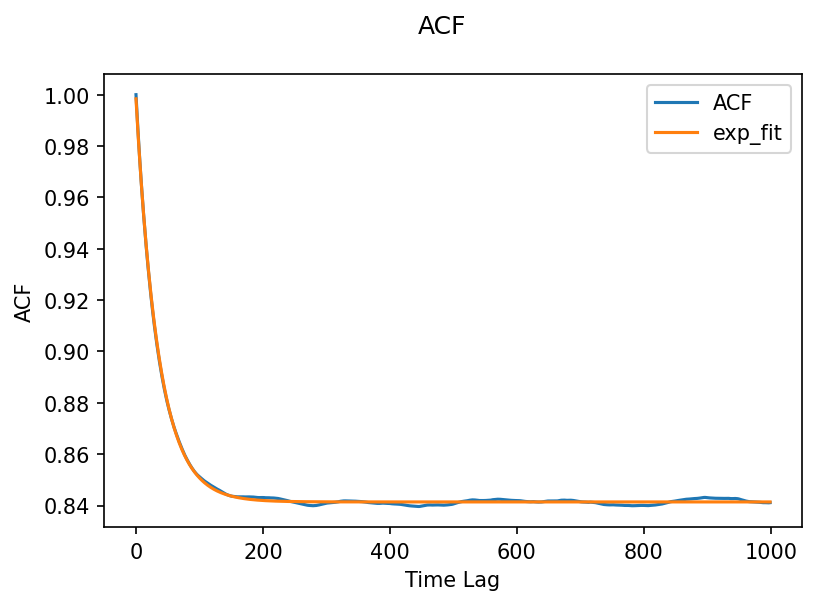

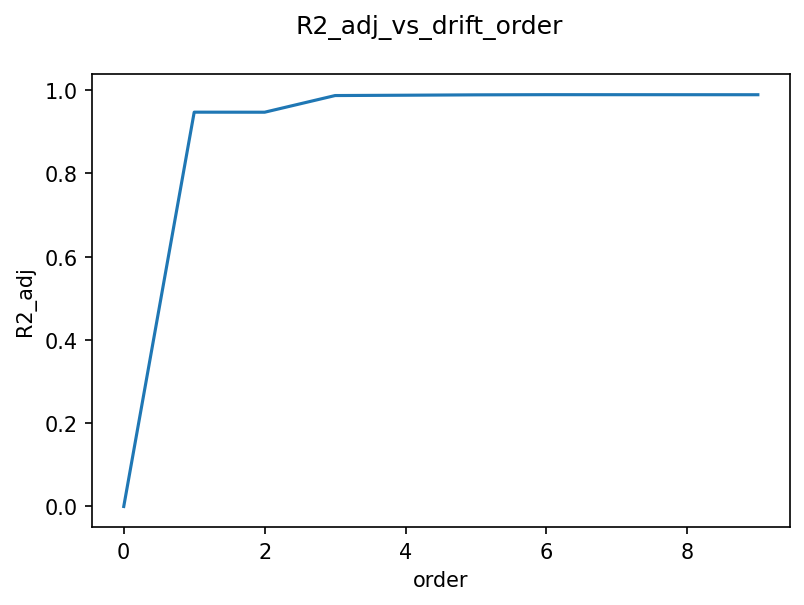

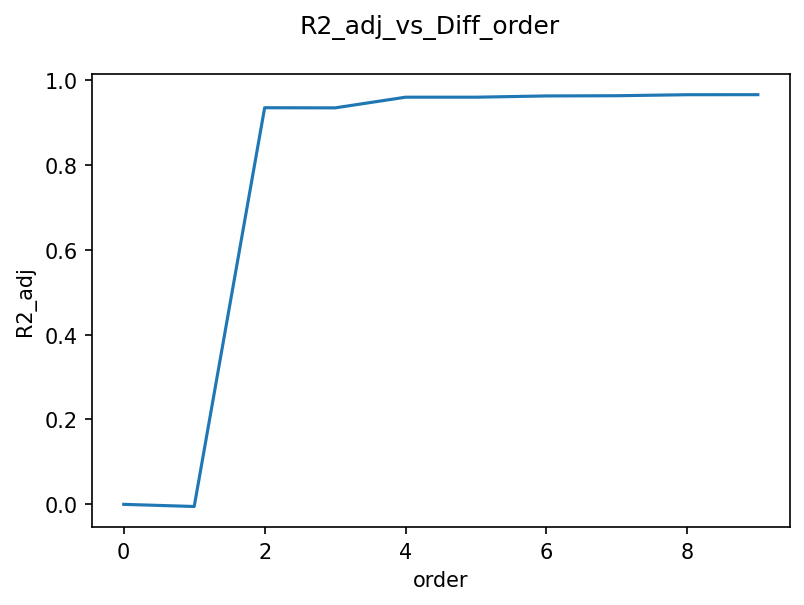

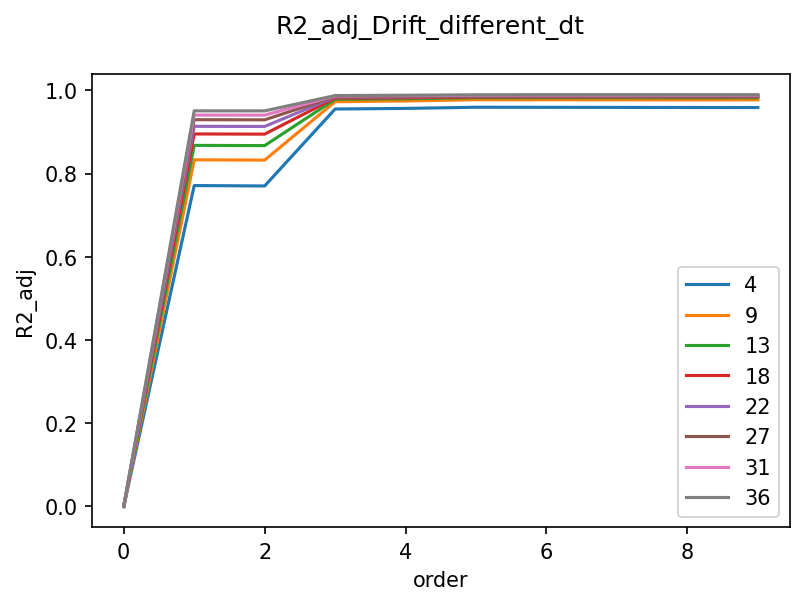

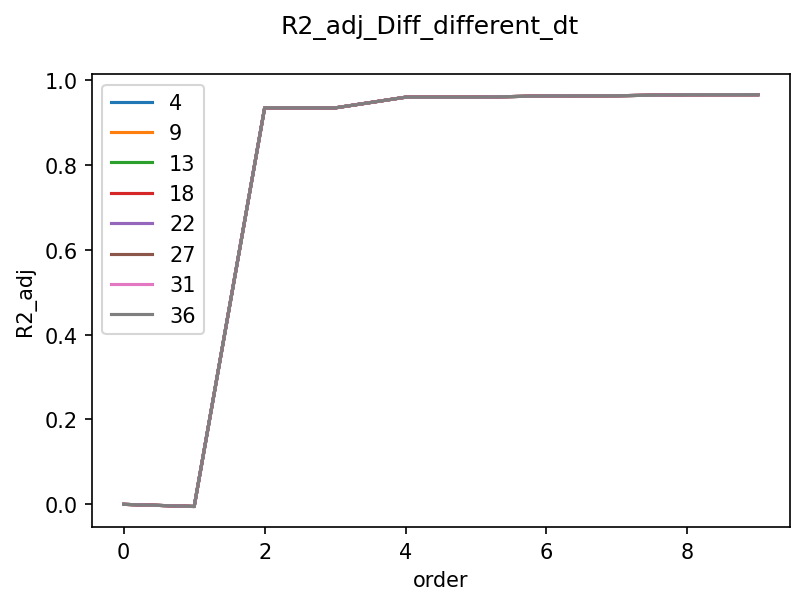

In [27]:
ch.diagnostic()

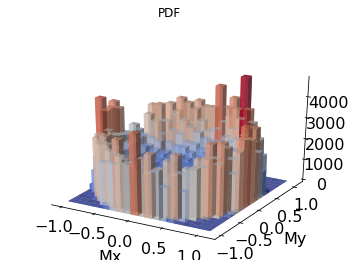

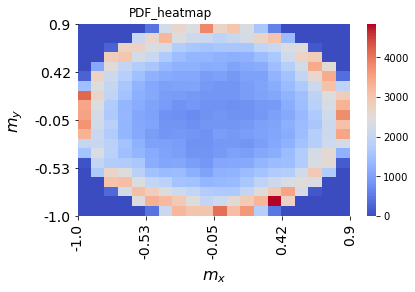

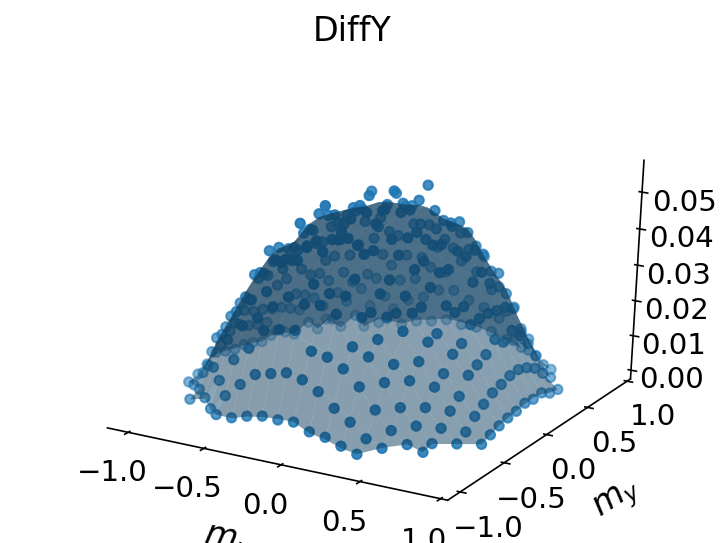

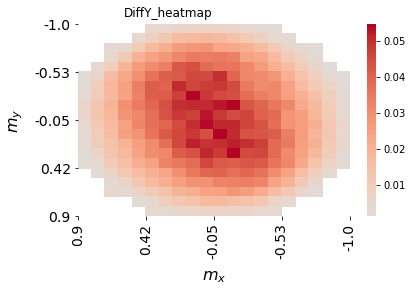

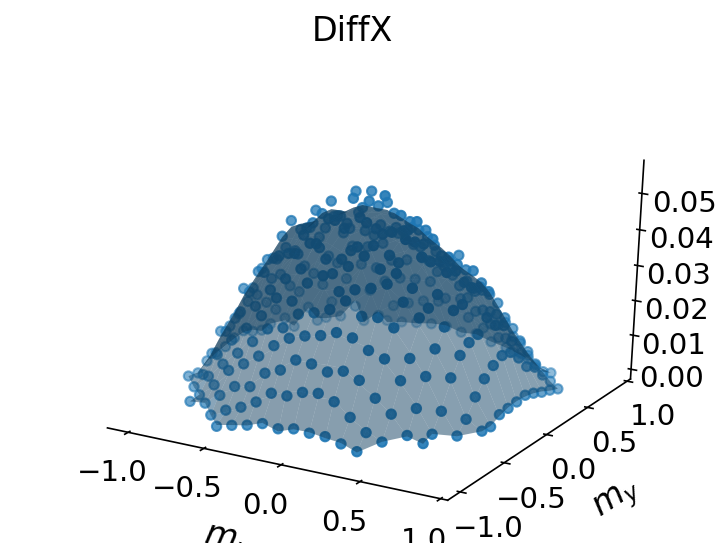

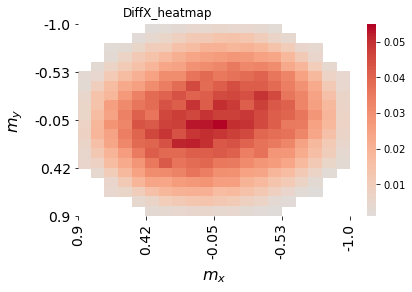

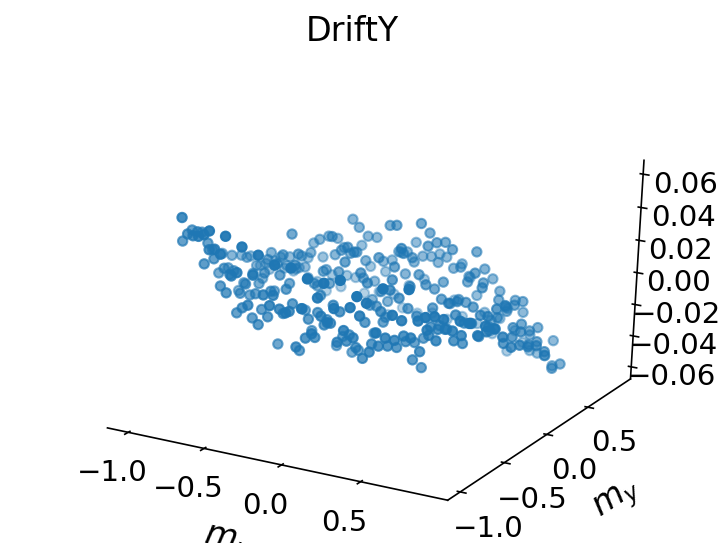

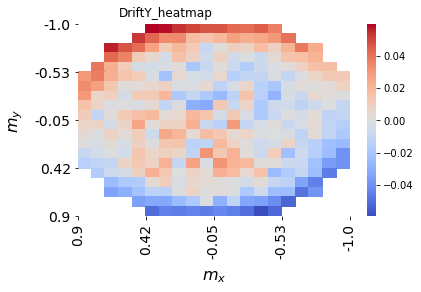

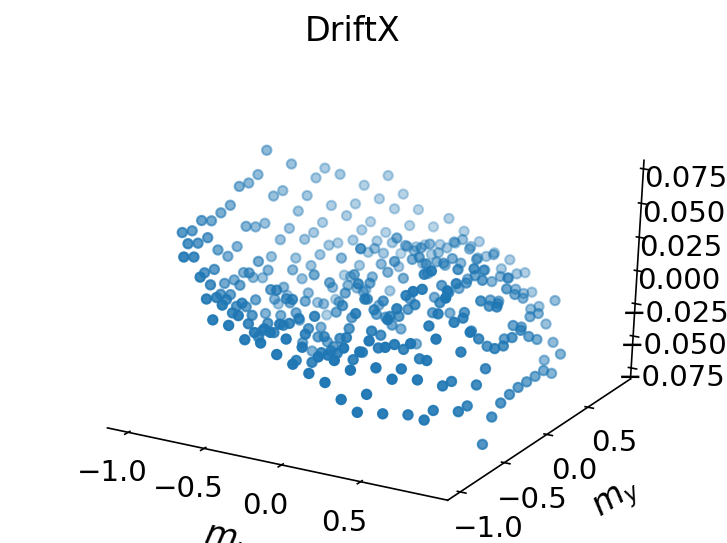

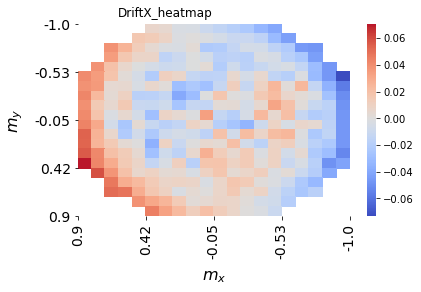

In [28]:
ch.visualize()

100%|██████████| 11390625/11390625 [12:49<00:00, 14808.72it/s]


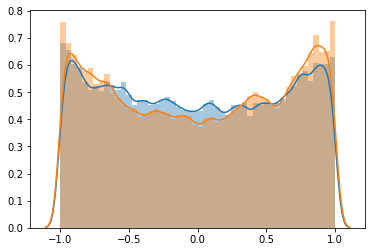

In [16]:
t, Mx, My = generate_ga_data(N=30, noise=np.pi, rates=[0.03, 1, 0.08, 0.008], iter_=15**6)
plt.figure()
sns.distplot(Mx)
sns.distplot(My)

In [17]:
np.savetxt('syn_quadanary.txt', np.vstack((Mx, My)).T)

In [36]:
Mx_4, My_4 = np.loadtxt('syn_quadanary.txt').T

In [37]:
ch = Characterize([Mx_4, My_4], t=None, t_int=0.12, dt='auto')
ch.parameters()

Gaussian check for underlying noise: 100%|██████████| 10000/10000 [00:07<00:00, 1408.20it/s]


{'dt_': 'auto',
 't_int': '0.12',
 't_lag': '1000',
 'simple_method': 'True',
 'max_order': '10',
 'inc': '0.01',
 'inc_x': '0.1',
 'inc_y': '0.1',
 'delta_t': '1',
 'order_metric': 'R2_adj',
 'fft': 'True',
 'drift_order': '1',
 'diff_order': '2',
 'n_trials': '1',
 'vector': 'True',
 'autocorrelation_time': '39.97921764642404',
 'dt': '39',
 'gaussian_noise': 'True',
 'k': '42.26625303297762',
 'l_lim': '-339.68886651149535',
 'h_lim': '320.66487131938936'}

<IPython.core.display.Javascript object>


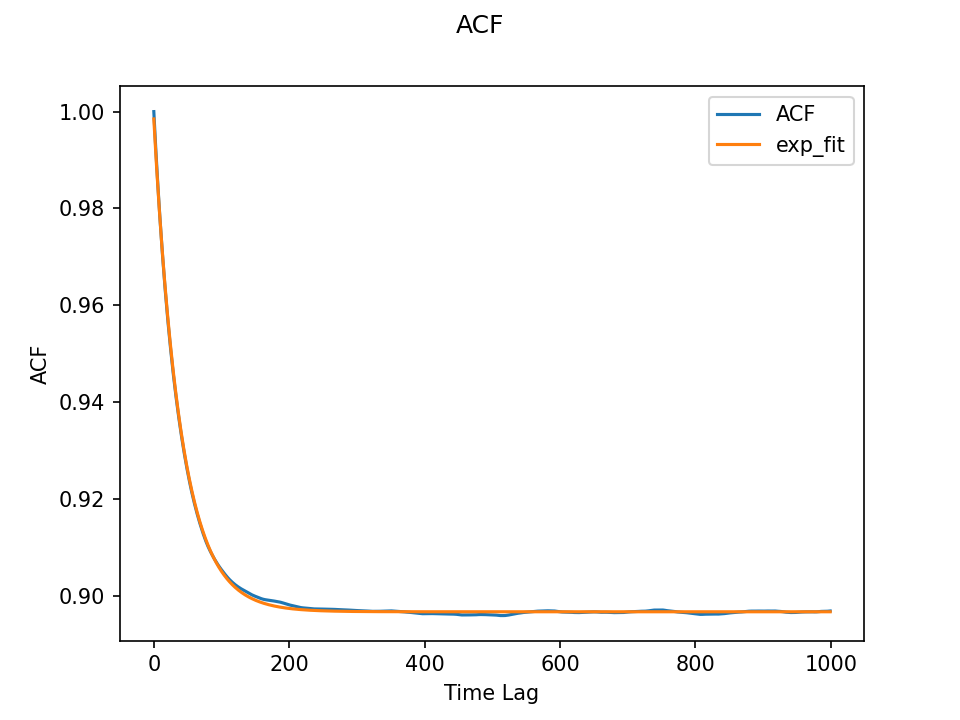

<IPython.core.display.Javascript object>


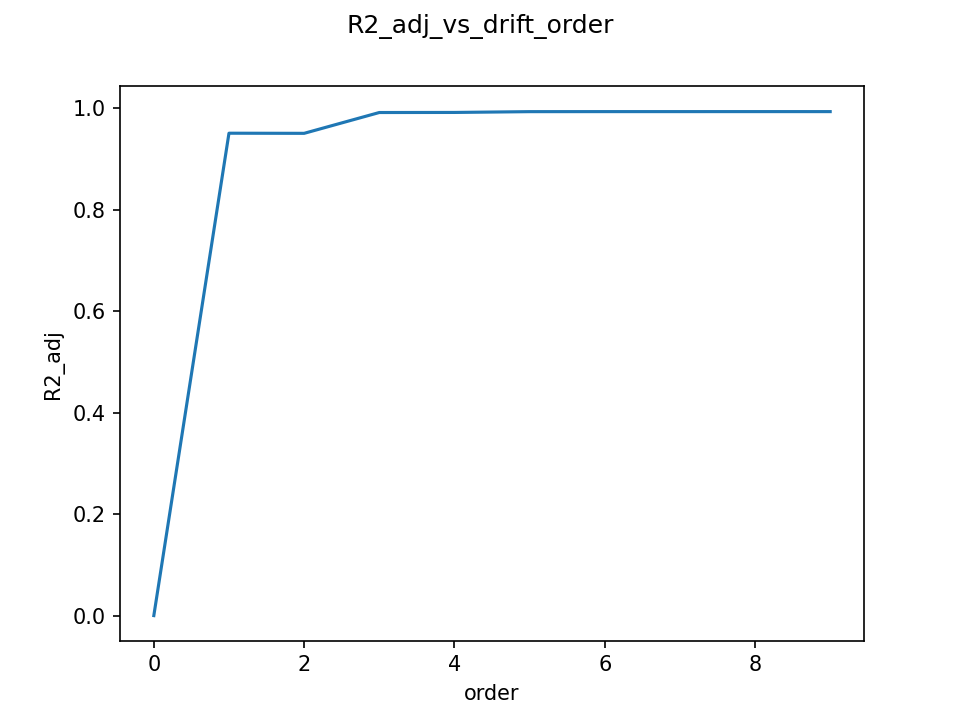

<IPython.core.display.Javascript object>


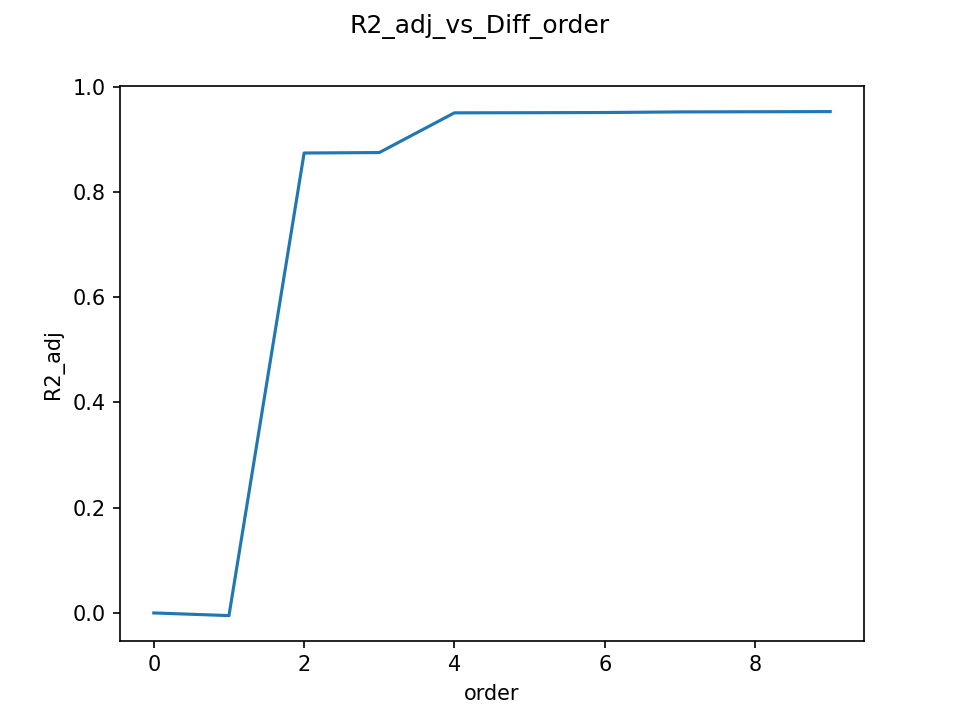

<IPython.core.display.Javascript object>


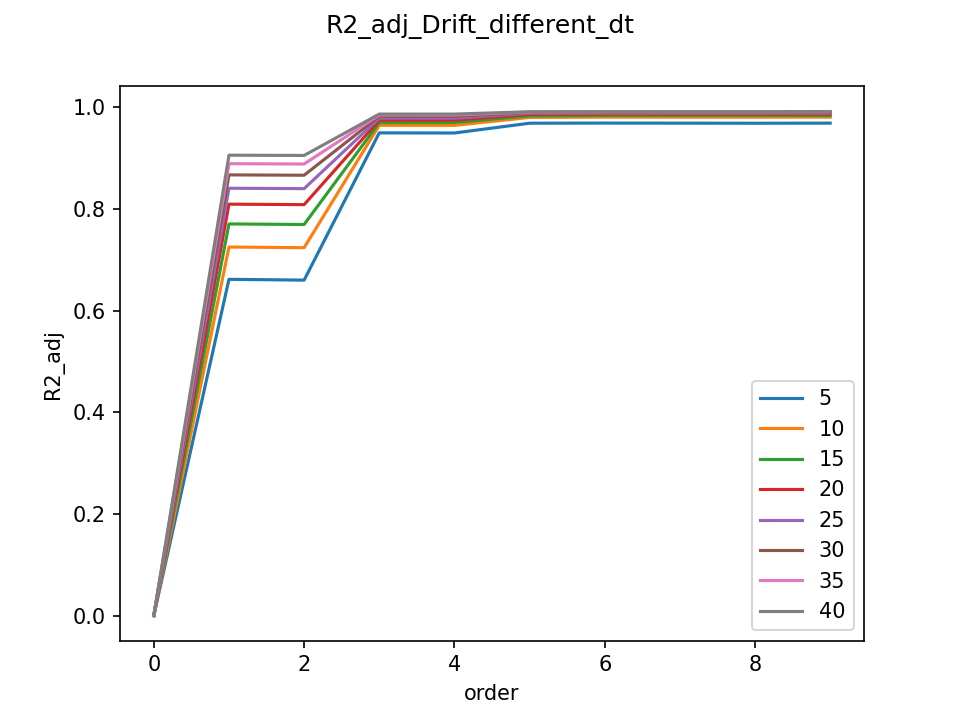

<IPython.core.display.Javascript object>


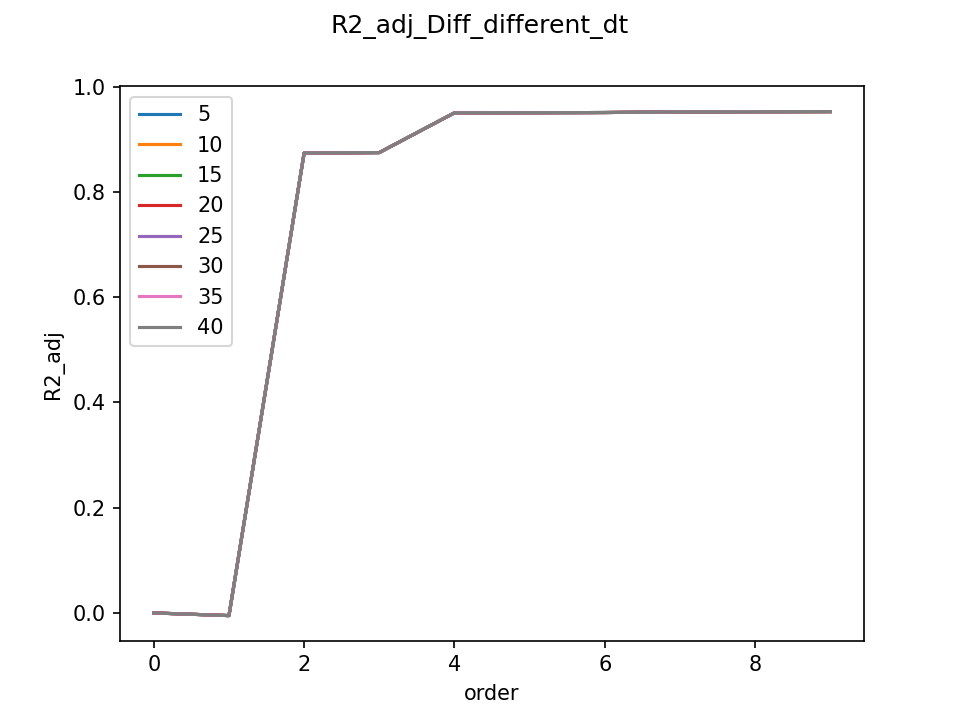

In [38]:
ch.diagnostic()

<IPython.core.display.Javascript object>


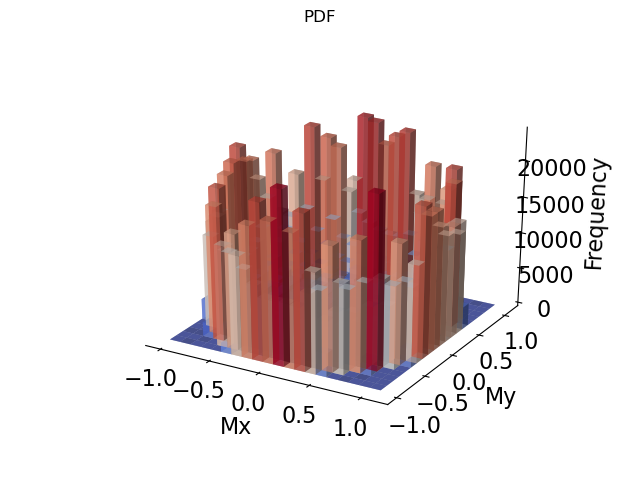

<IPython.core.display.Javascript object>


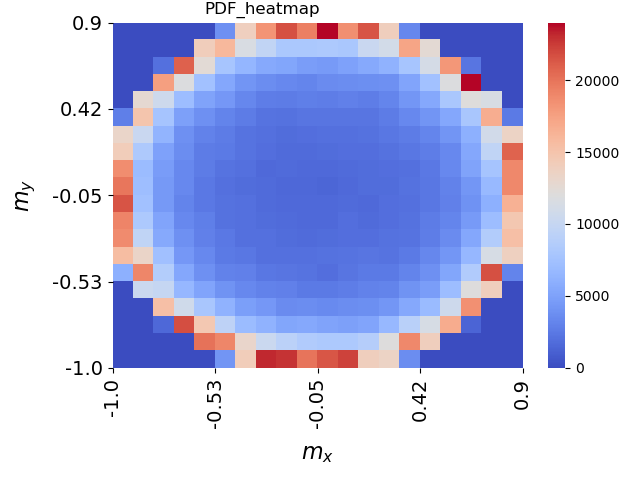

<IPython.core.display.Javascript object>


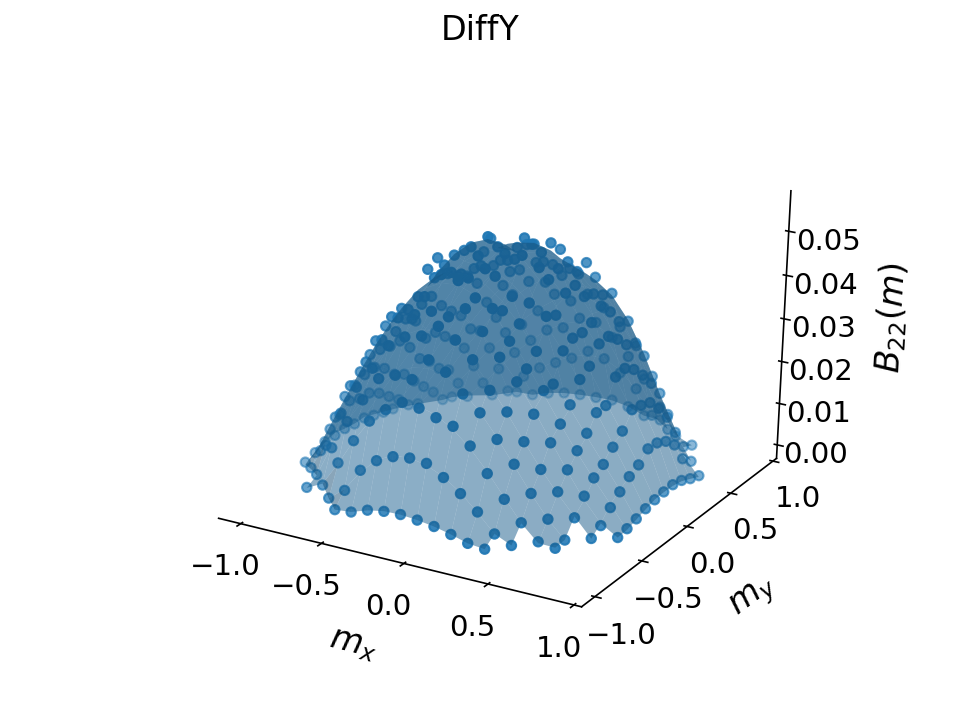

<IPython.core.display.Javascript object>


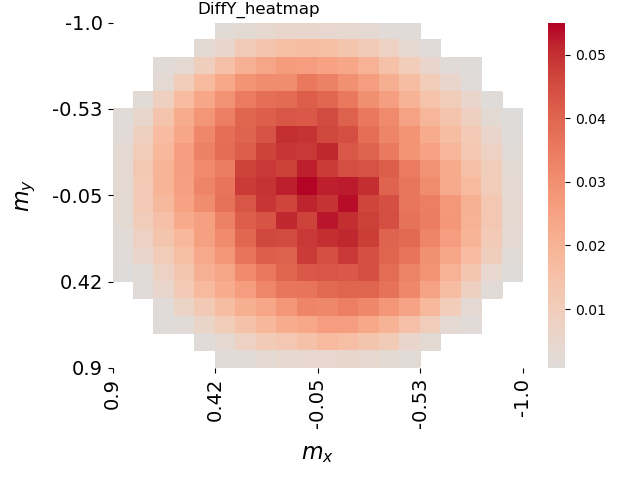

<IPython.core.display.Javascript object>


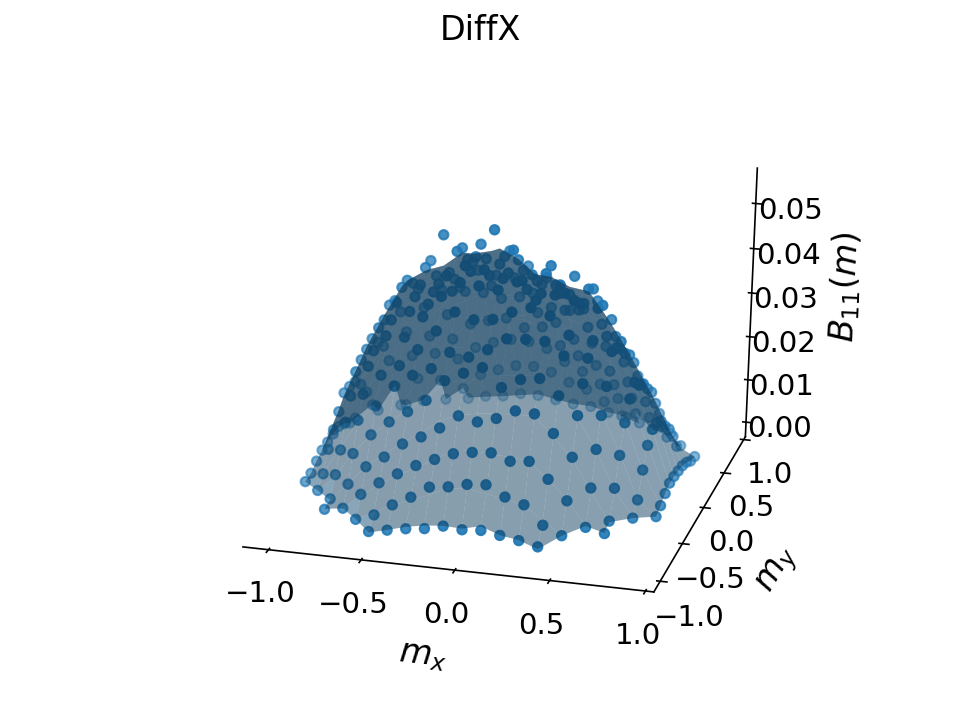

<IPython.core.display.Javascript object>


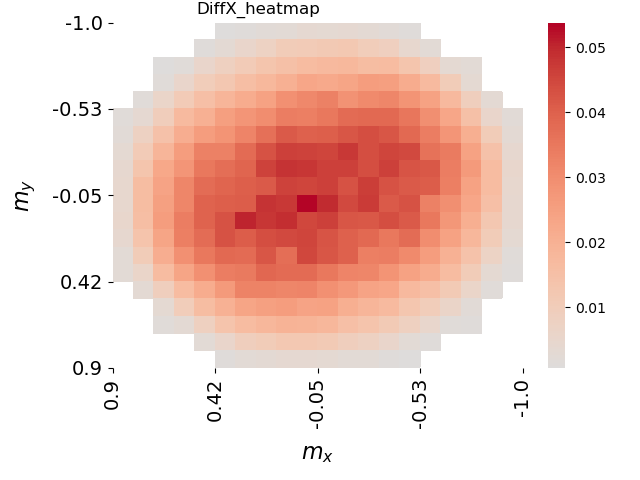

<IPython.core.display.Javascript object>


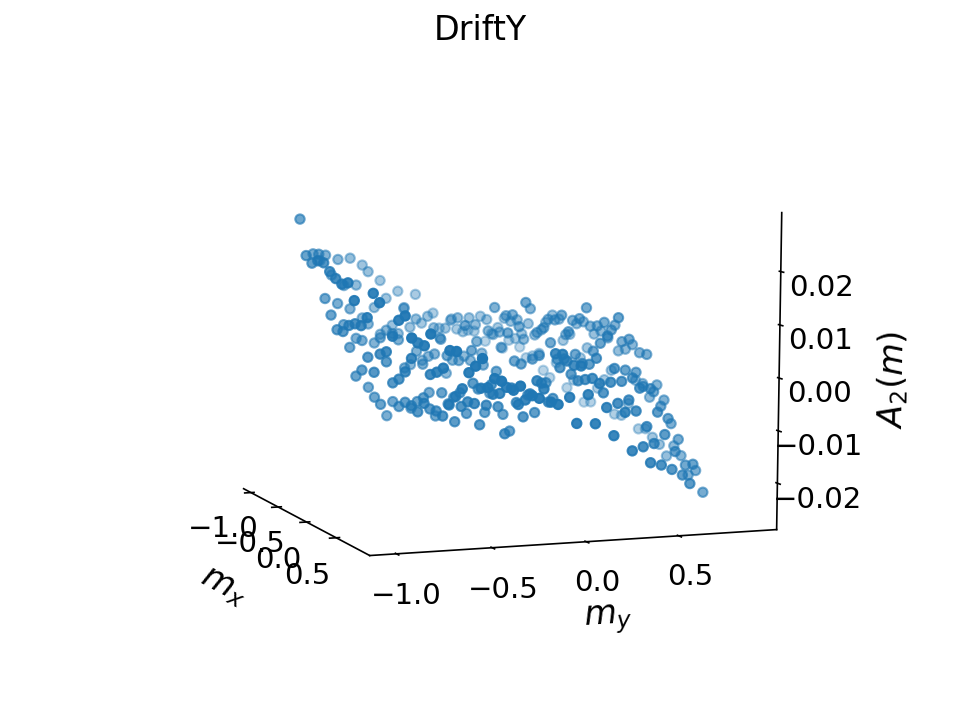

<IPython.core.display.Javascript object>


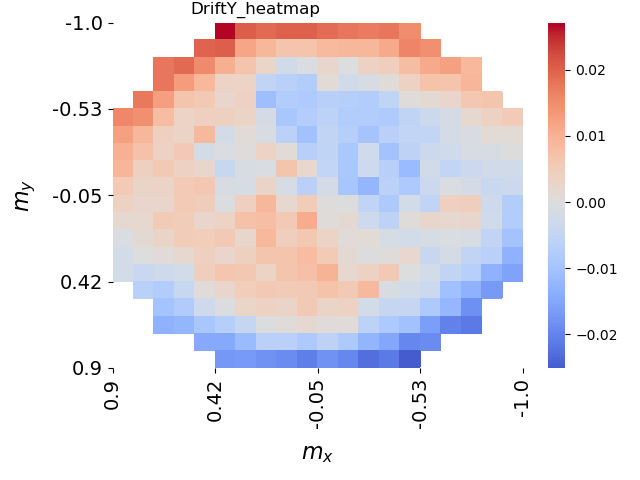

<IPython.core.display.Javascript object>


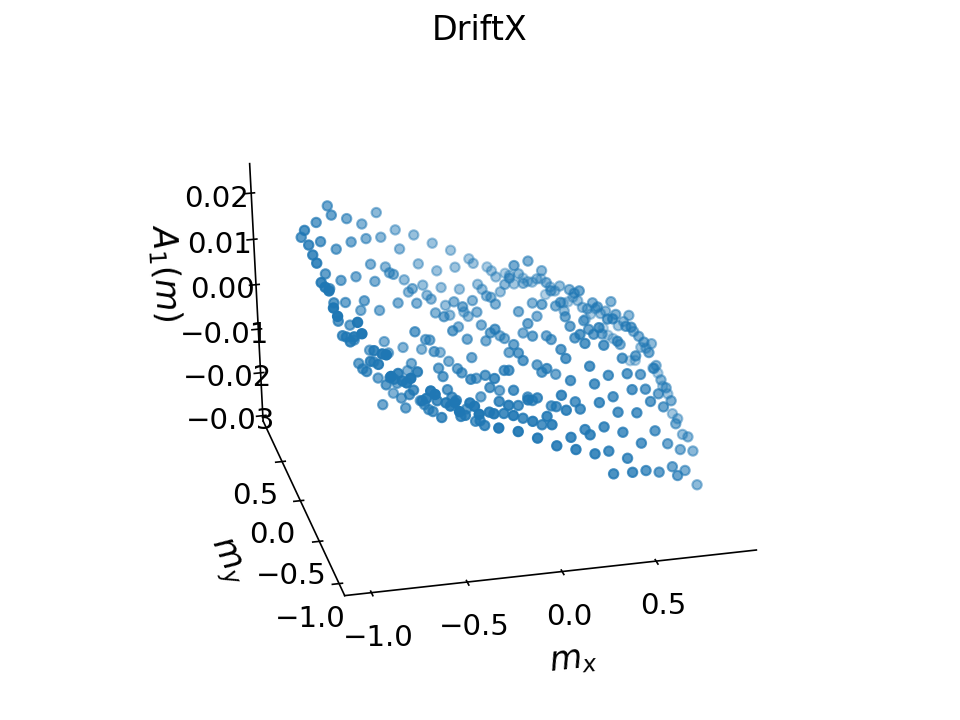

<IPython.core.display.Javascript object>


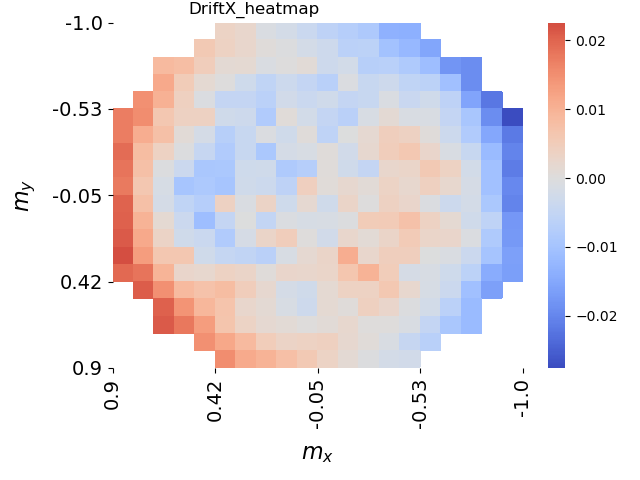

In [39]:
ch.visualize()

100%|██████████| 11390625/11390625 [26:34<00:00, 7141.94it/s]


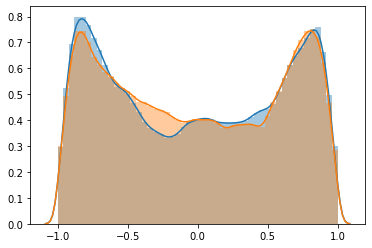

In [18]:
t, Mx, My = generate_ga_data(N=30, noise=np.pi, rates=[0.05, 0.1, 0.04, 0.02, 0.05], iter_=15**6)
plt.figure()
sns.distplot(Mx)
sns.distplot(My)

In [19]:
np.savetxt('syn_pentanery.txt', np.vstack((Mx, My)).T)

In [41]:
Mx_5, My_5 = np.loadtxt('syn_pentanery.txt').T

In [54]:
import pyFish
import scipy.optimize

In [95]:
def acf_fft(data, t_lag):
    x = np.arange(0, t_lag)
    c = np.fft.ifft(np.square(np.abs(np.fft.fft(data))))
    c /= max(c)
    return x,c[0:t_lag]

def fit_exp(x, y):
    fn = lambda t,a,b,c: a*np.exp((-1/b)*t) + c
    coeff1, coeff2 = scipy.optimize.curve_fit(fn, x, y)
    return coeff1, coeff2

fn = lambda t,a,b,c: a*np.exp((-1/b)*t) + c

In [106]:
x, cor = acf_fft(np.sqrt(Mx_3**2+My_3**2), 1000)

In [107]:
c1, c2 = fit_exp(x,cor)
a,b,c = c1
b

35.47125046275508

<IPython.core.display.Javascript object>


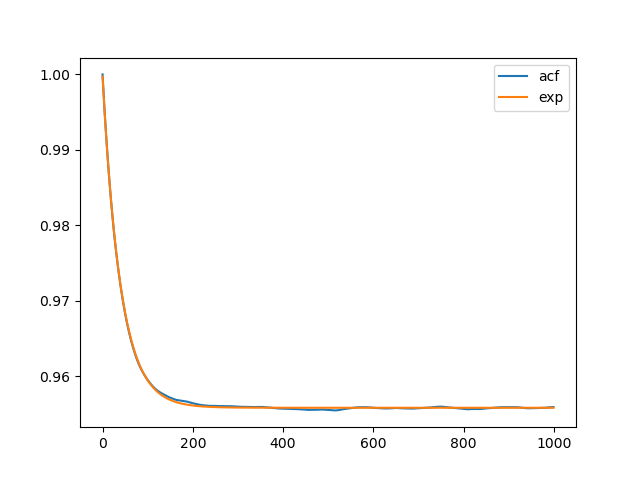

40.083944215115814

In [78]:
plt.figure()
plt.plot(x,cor, label='acf')
plt.plot(x, fn(x, a,b,c), label='exp')
plt.legend()
plt.show()
b

In [42]:
ch = Characterize([Mx_5, My_5], t=None, t_int=0.12, dt=10)
ch.parameters()

Gaussian check for underlying noise: 100%|██████████| 10000/10000 [00:15<00:00, 660.13it/s]


{'dt_': '10',
 't_int': '0.12',
 't_lag': '1000',
 'simple_method': 'True',
 'max_order': '10',
 'inc': '0.01',
 'inc_x': '0.1',
 'inc_y': '0.1',
 'delta_t': '1',
 'order_metric': 'R2_adj',
 'fft': 'True',
 'drift_order': '1',
 'diff_order': '4',
 'n_trials': '1',
 'vector': 'True',
 'autocorrelation_time': '21.347565931231475',
 'dt': '10',
 'gaussian_noise': 'True',
 'k': '22.081032899232664',
 'l_lim': '-533.7537576811962',
 'h_lim': '548.9855226927978'}

<IPython.core.display.Javascript object>


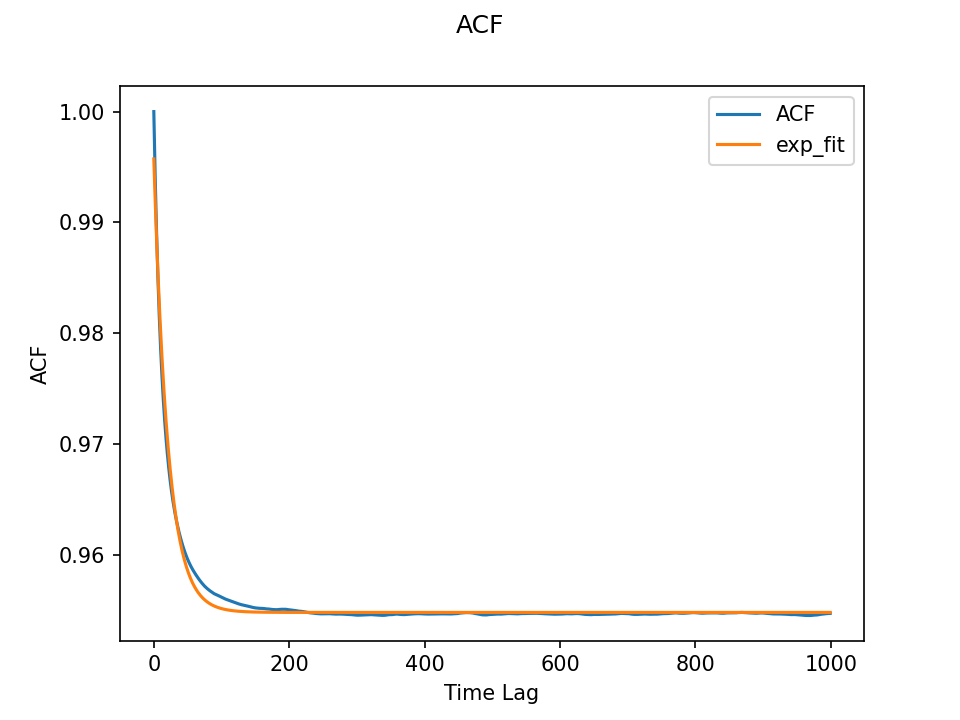

<IPython.core.display.Javascript object>


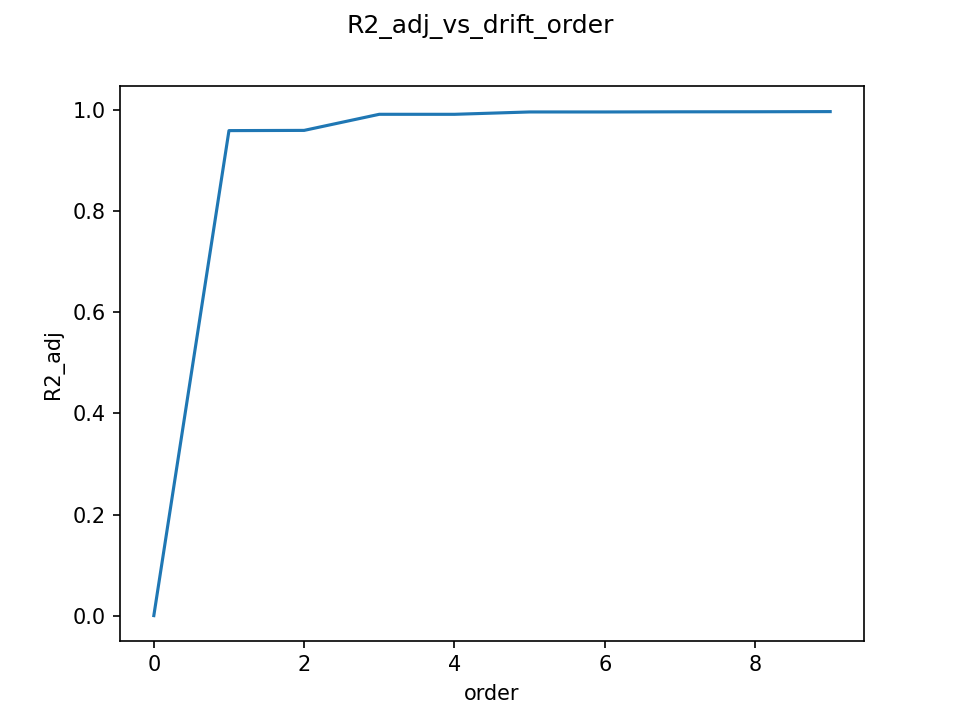

<IPython.core.display.Javascript object>


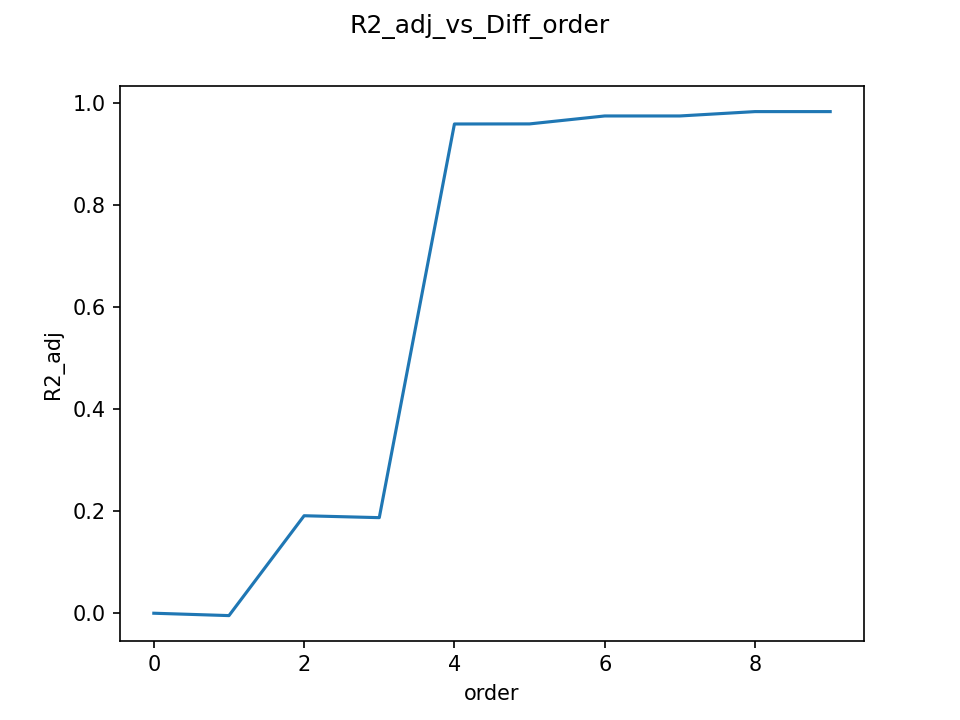

<IPython.core.display.Javascript object>


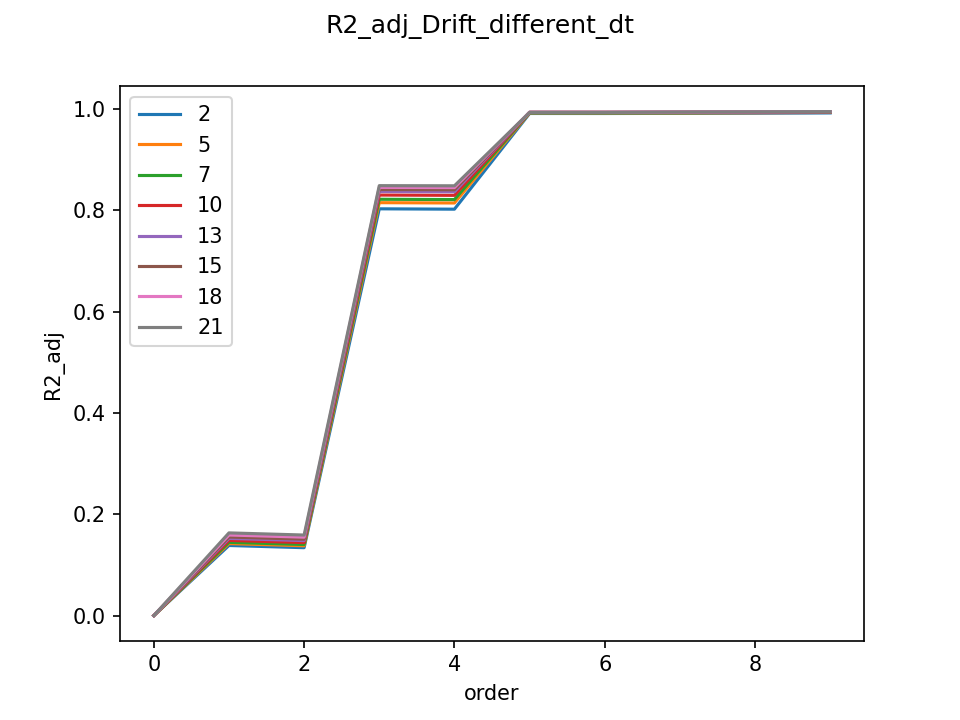

<IPython.core.display.Javascript object>


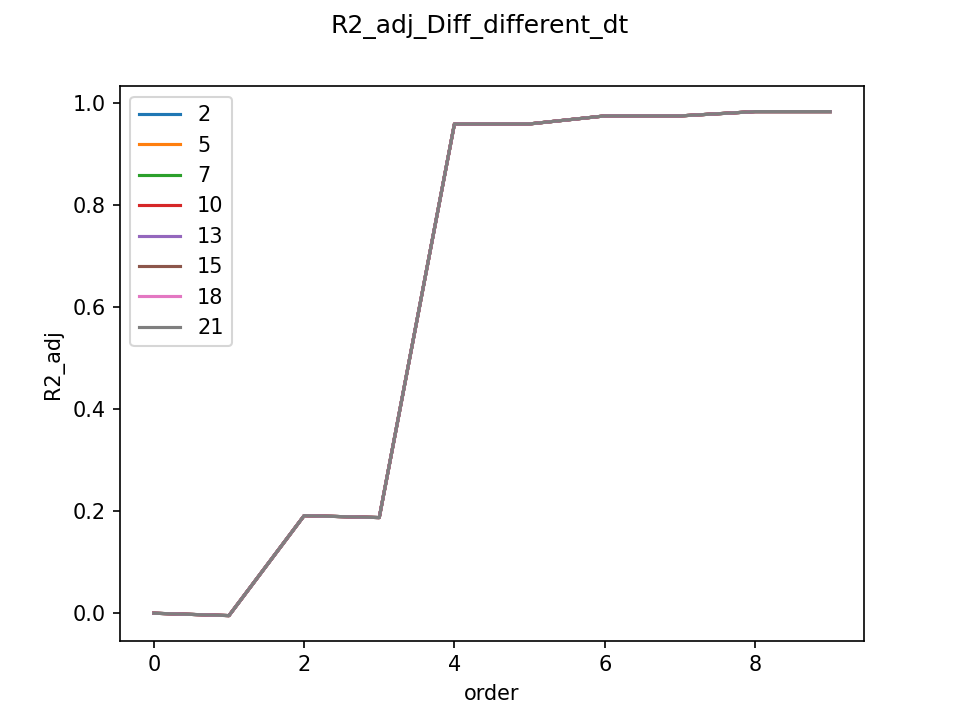

In [698]:
ch.diagnostic()

<IPython.core.display.Javascript object>


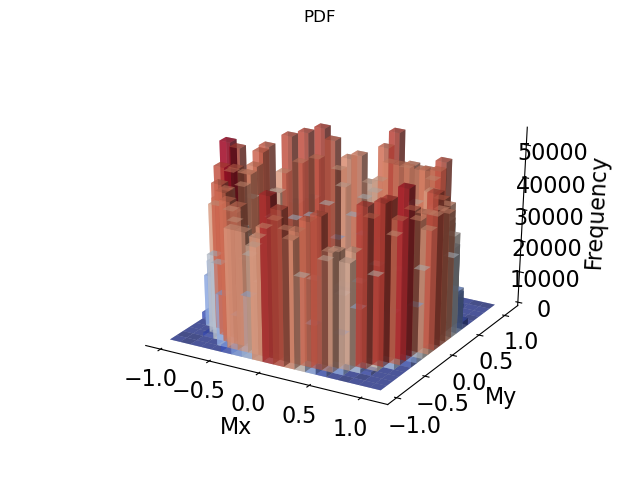

<IPython.core.display.Javascript object>


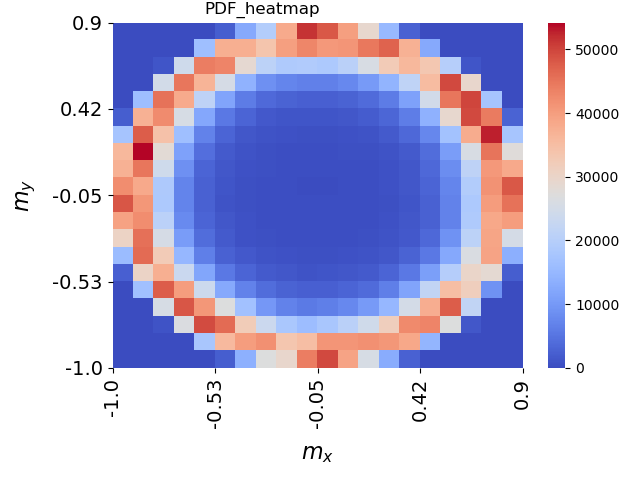

<IPython.core.display.Javascript object>


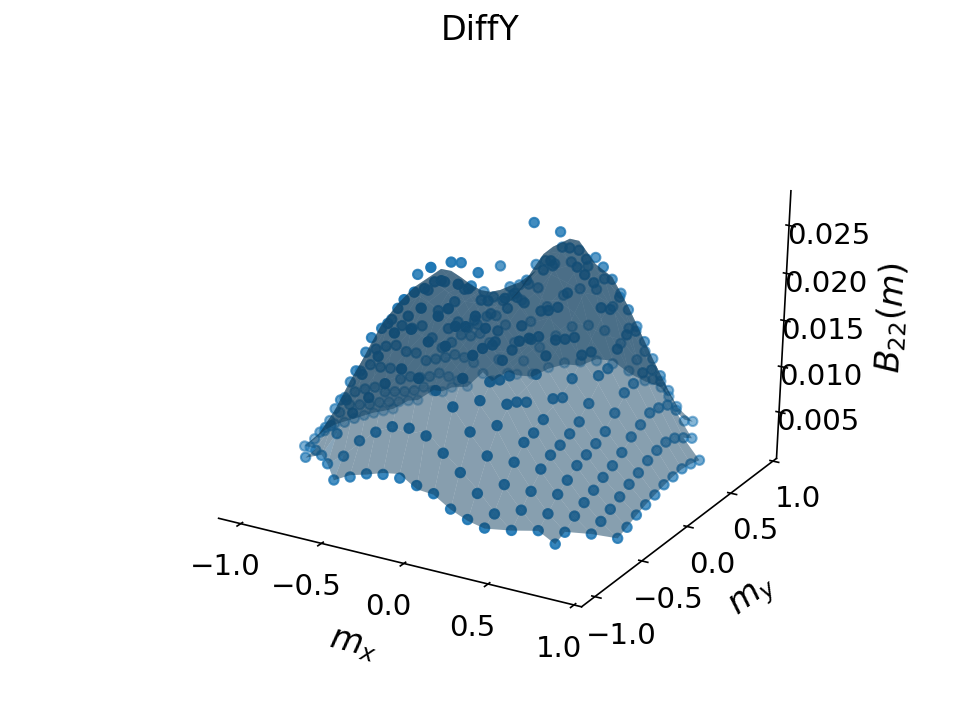

<IPython.core.display.Javascript object>


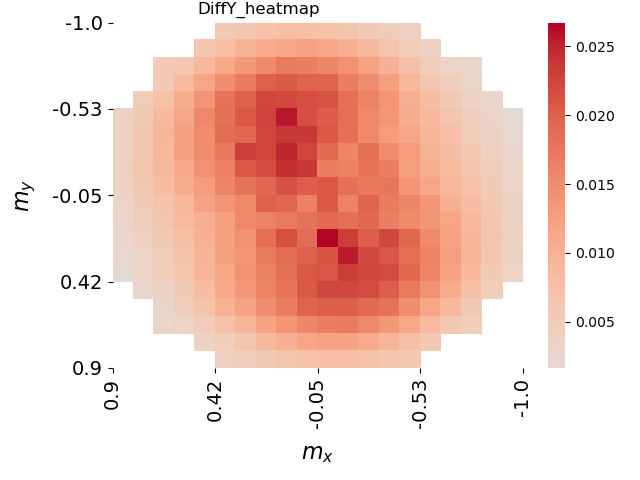

<IPython.core.display.Javascript object>


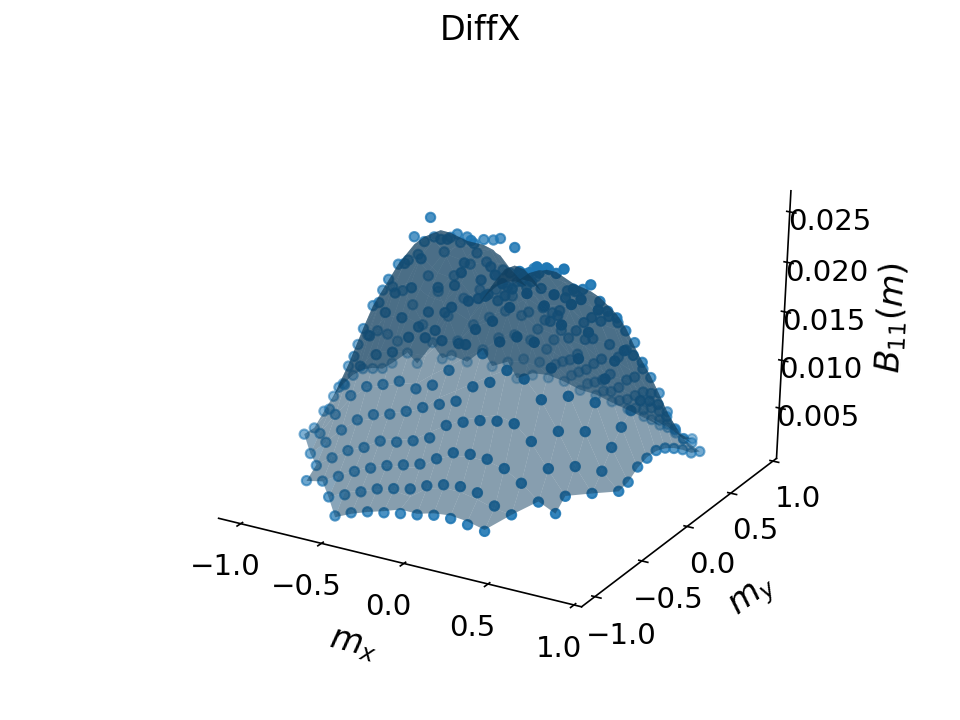

<IPython.core.display.Javascript object>


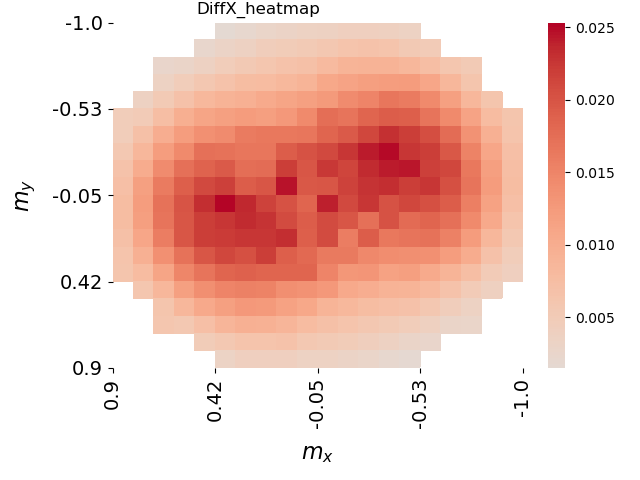

<IPython.core.display.Javascript object>


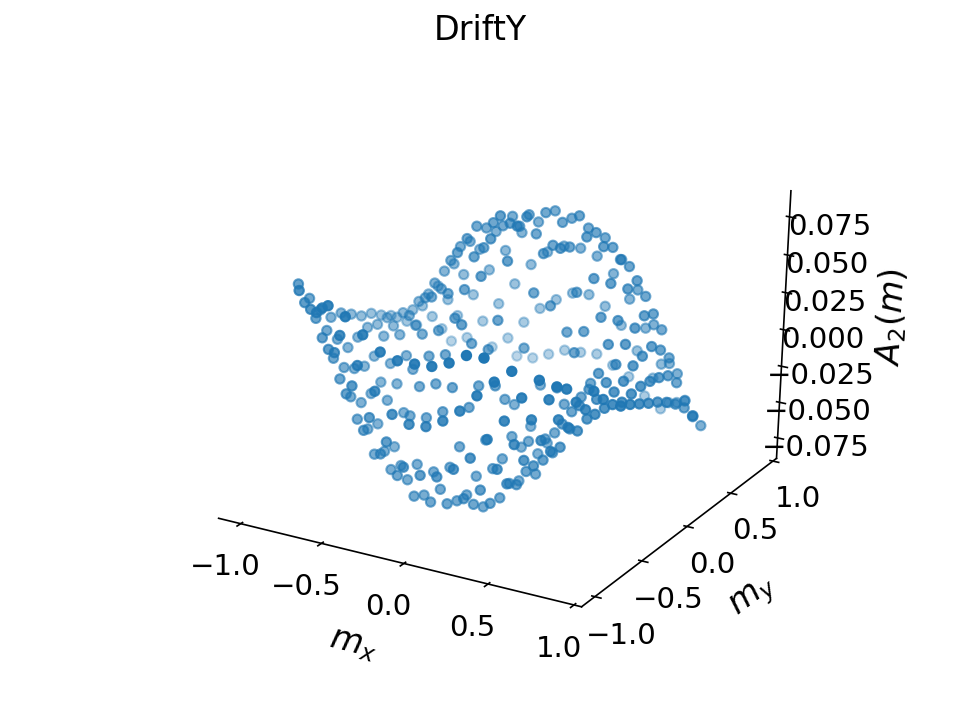

<IPython.core.display.Javascript object>


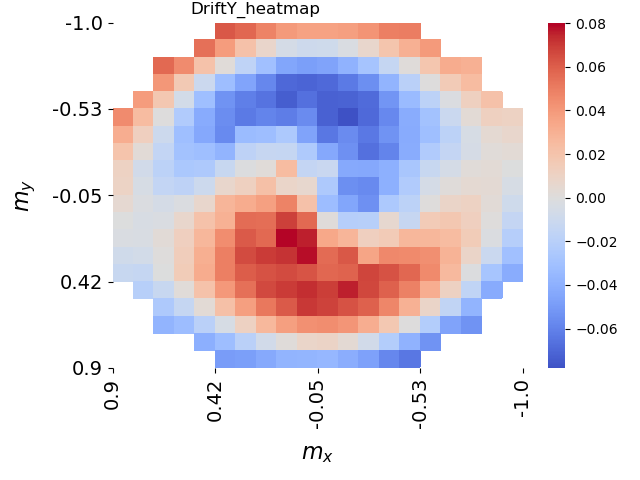

<IPython.core.display.Javascript object>


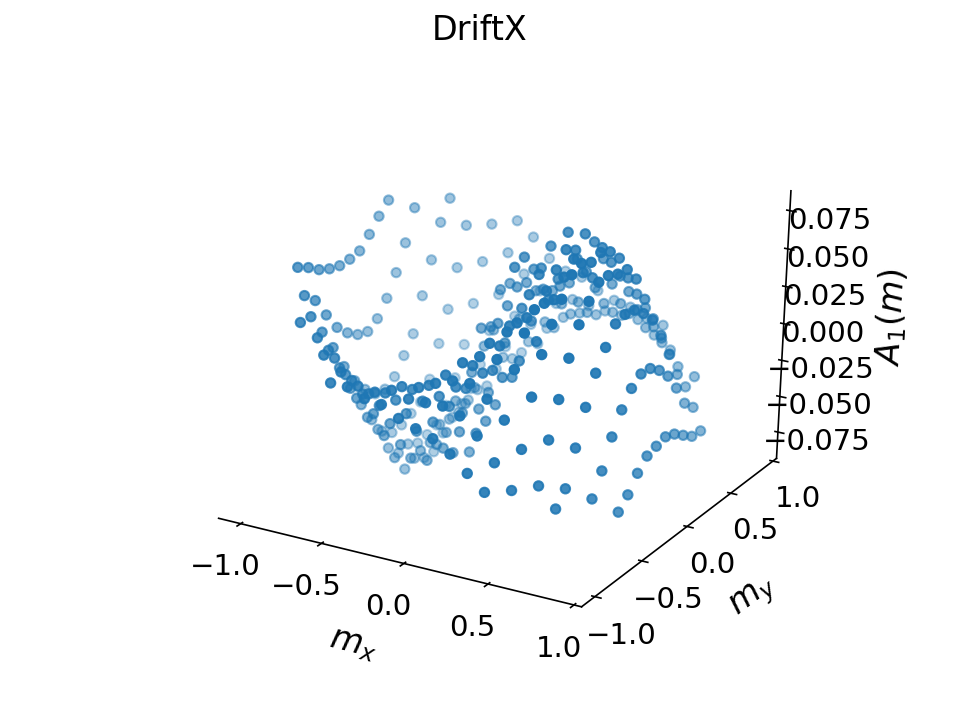

<IPython.core.display.Javascript object>


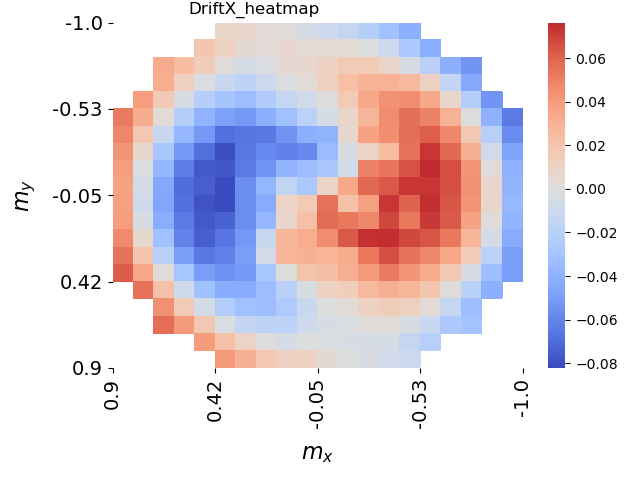

In [108]:
ch.visualize()